# BRIDGET: ADULT

Clean version from: https://github.com/pellungrobe/XAI_course_2024/blob/main/tabular%20datasets


## Dataset Preprocessing


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import yaml
import random
import time
import functools
import pickle
import re
import orjson
import alibi
import ignite
import copy

from IPython import display
from itertools import combinations, product
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import Counter

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optimizer

import fatf.utils.data.datasets as fatf_datasets
import fatf.fairness.data.measures as fatf_dfm
import fatf.utils.data.tools as fatf_data_tools

from river import rules, tree, datasets, drift, metrics, evaluate
from river import imblearn
from river import preprocessing
from river import optim
from river import metrics
from river import feature_extraction, feature_selection
from river import ensemble, linear_model, forest, compose

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine


from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

from alibi.explainers.cfproto import CounterFactualProto

from bridget_utils import *
from classes import BetaUser, DeferralNet, PyTorchWrapper, RiverModelWrapper
from bridget_mod import BRIDGET, HiC, MiC


c:\Users\virgm\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


26-Feb-02 12:45:50 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [3]:
data= pd.read_csv(r".\datasets\adult_clean.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             30162 non-null  int64
 1   workclass       30162 non-null  int64
 2   fnlwgt          30162 non-null  int64
 3   education-num   30162 non-null  int64
 4   marital-status  30162 non-null  int64
 5   occupation      30162 non-null  int64
 6   relationship    30162 non-null  int64
 7   race            30162 non-null  int64
 8   sex             30162 non-null  int64
 9   capital-gain    30162 non-null  int64
 10  capital-loss    30162 non-null  int64
 11  hours-per-week  30162 non-null  int64
 12  native-country  30162 non-null  int64
 13  class           30162 non-null  int64
dtypes: int64(14)
memory usage: 3.2 MB


In [4]:
# a quanto pare fnl wgt è una variabile statistica che rappresenta il # persone che vengono rappresentate da quel record
# provo a lanciare bridget senza chiamarla

data= data.drop(columns= ['fnlwgt'])
data.columns = [str(c).strip() for c in data.columns]


Label is "class", let's first assess the distrib

14 cols, 30162 rows, no need to preprocess stuff

Protected attributes: [age, race, sex]

No missing Vals, approx 100 duplicates, i'll leave them to assess how Bridget fares with them

Label very unbalances, 75/25 thus need to split while applying a proportion as i cant use the sklearn stratify

In [5]:
# Qui definiamo i vari split dei flussi 

data = data.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle iniziale

class_0 = data[data['class'] == 0]
class_1= data[data['class'] == 1]


def stratif(start_point, end_point):
    class_0_perc= class_0.iloc[int(len(class_0)*start_point) : int(len(class_0)*end_point)]
    class_1_perc= class_1.iloc[int(len(class_1)*start_point) : int(len(class_1)*end_point)]

    total= pd.concat([class_0_perc, class_1_perc]).sample(frac=1, random_state= 42).reset_index(drop=True)
    #chiaramente se c'è il concat bisogna rifare lo shuffle

    return total

In [6]:
#  split ufficiale

calibration_data= stratif(0.6, 0.8)
mic_data= stratif(0.8, 1.0)

avv_train= stratif(0.0, 0.08)
avv_test= stratif(0.08, 0.1)

hic_train= stratif(0.1, 0.5)
hic_test= stratif(0.5, 0.6)

print(len(calibration_data))
print(len(mic_data))

print(len(avv_train))
print(len(avv_test))

print(len(hic_train))
print(len(hic_test))

6033
6033
2412
603
12066
3015


In [7]:
numericals= ['age','capital-gain','capital-loss', 'hours-per-week','education-num']

categoricals= [c for c in data.columns if c not in numericals and c != 'class']

prepr_transf = (
    (compose.Select(*numericals) | preprocessing.StandardScaler()) +
    compose.Select(*categoricals)
)

In [8]:
## trasformazione in df perchè servono per il logging e come lookup delle istanze (batch1 e batch3)

df_batch_1 = pd.concat([hic_train, hic_test]).reset_index(drop=True)

df_avv= pd.concat([avv_train, avv_test]).reset_index(drop=True)
df_avv.head(n=5)


,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,2,9,1,6,1,2,0,0,0,30,41,0
1,31,0,10,1,10,1,1,0,0,0,35,41,1
2,68,2,13,1,1,1,1,0,0,0,40,41,1
3,32,2,13,1,1,1,1,0,0,0,45,41,1
4,56,2,10,1,10,1,1,0,0,0,45,41,0


In [9]:
## ora divisione in x e y

target= 'class'

# avviamento 
X_avv_train = avv_train.drop(columns=[target])
y_avv_train = avv_train[target]

X_avv_test = avv_test.drop(columns=[target])
y_avv_test = avv_test[target]


# hic
X_hic_train = hic_train.drop(columns=[target])
y_hic_train = hic_train[target]

X_hic_test = hic_test.drop(columns=[target])
y_hic_test = hic_test[target]
# validation
X_val = calibration_data.drop(columns=[target])
y_val = calibration_data[target]

# mic
X_mic = mic_data.drop(columns=[target])
y_mic = mic_data[target]

## Calibration Phase: Experts and Incremental Model Selection

In [10]:
with open(r".\experts_adult.yaml", "r") as f:
    config= yaml.safe_load(f)


params_dict= config['experts']['groups']['w_dict']
#feat_order= list(config['experts']['groups']['w_dict'].keys())


### Calibrating Incremental Model

The incremental model to be chosen for Bridget is trained on the X_avv, y_avv portion of the dataset,then evaluated on the X_avv_test and y_avv_test

The calibration phase starts by assessing the results of the learning for several configurations:

    - HoeffdingTreeClassifier

    - ExtremelyFastDecisionTreeClassifier

    - AdaBoostClassifier            (base= SGTClassifier)

    - AdwinBaggingClassifier        (base= SGTClassifier)

    - SRPClassifier                 (base= SGTClassifier)

    - AdaptiveRandomForestClassifier


The metrics observed are the Accuracy, the F1Score and the Counters for the classes

In [11]:
# since all River models work with dicts, lets first transform the dfs to dict
X_avv_df = pd.DataFrame(X_avv_train)
X_avv_test= pd.DataFrame(X_avv_test)

X_avv_dict= X_avv_df.to_dict(orient='records')
X_avv_dict_test= X_avv_test.to_dict(orient='records')


# setting the init params required by HIC class
RULE = True
PAST = True
SKEPT = True
GROUP = True
EVA=    True
N_BINS = 10
N_VAR = 3
MAX = 5

test_batch_1= pd.DataFrame(X_hic_test)

test_batch_1['class']= y_hic_test


target= 'class'

rule_att = 'capital-gain' # a random rule
rule_value = 0.9 # viene scalata anyways

protected= ['race', 'age', 'sex']


In [12]:
# then the models are instantiated and trained by the HiC.train function
# the HiC object is initialized by passing a random user model, its not relevant since it won't interact with the IL anyways

expert= 'accurate_trusting'

sgt_base = tree.SGTClassifier(
    grace_period=100,  # Leggermente più basso per imparare prima
    feature_quantizer=tree.splitter.DynamicQuantizer()
)


htree= tree.HoeffdingAdaptiveTreeClassifier(grace_period= 100)
efdt= tree.ExtremelyFastDecisionTreeClassifier(grace_period=100)
ada= ensemble.AdaBoostClassifier(model= sgt_base, n_models= 8, seed= 42)  
adwin= ensemble.ADWINBaggingClassifier(model= sgt_base, n_models= 8, seed= 42)
srp= ensemble.SRPClassifier(model= sgt_base, n_models=8, seed= 42)
arf= forest.ARFClassifier(n_models= 8, grace_period= 50, max_features='sqrt', seed=42)

models= [htree, efdt, ada, adwin, srp, arf]


for model in models:
    bridget_inst= HiC(expert, df_batch_1, mic_data, test_batch_1, target, prepr_transf,
                0.6, expert,
                protected, categoricals, numericals,  0.7,  0.5,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, rule_att, rule_value, model)

    
    bridget_inst.train(X_avv_dict, y_avv_train, X_avv_dict_test, y_avv_test)

trained_arf= arf

Accuracy: 81.59%
F1: 43.65%
Distribution of predictions: Counter({0: 556, 1: 47})
HoeffdingAdaptiveTreeClassifier trained
Accuracy: 83.91%
F1: 62.84%
Distribution of predictions: Counter({0: 492, 1: 111})
ExtremelyFastDecisionTreeClassifier trained
Accuracy: 79.77%
F1: 37.76%
Distribution of predictions: Counter({False: 557, True: 46})
AdaBoostClassifier(SGTClassifier) trained
Accuracy: 75.12%
F1: 0.00%
Distribution of predictions: Counter({False: 603})
ADWINBaggingClassifier(SGTClassifier) trained
Accuracy: 76.12%
F1: 8.86%
Distribution of predictions: Counter({False: 595, True: 8})
SRPClassifier(SGTClassifier) trained
Accuracy: 83.58%
F1: 65.02%
Distribution of predictions: Counter({0: 470, 1: 133})
ARFClassifier trained


### Calibrating Experts

For the Adult dataset the .search_bounds function was not capable to find the bounds at all, even after doubling the search range and running 10 iters

Thus i pre-trained the IL models first, which update the scaler, then transformed the columns for the expert to be fitted on

In [13]:
## getting a balanced split out of the training section because .fit doesnt really work

temp_data= X_hic_train.copy()
temp_data['target']= y_hic_train

df_0 = temp_data[temp_data['target'] == 0].sample(n=(y_hic_train==1).sum(), random_state= 42)
df_1= temp_data[temp_data['target'] == 1]

print(len(df_0))
print(len(df_1))


3004
3004


In [14]:
expert_data= pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)

X_exp= expert_data.drop(columns=['target']).to_dict(orient='records')
y_exp= expert_data['target']

X_exp_scaled= []

for x in X_exp:
    X_exp_scaled.append(prepr_transf.transform_one(x))

X_exp_final = pd.DataFrame(X_exp_scaled)

In [15]:
experts_obj= {}

expert_names = ['accurate_trusting', 'accurate_not_trusting', 
                'inaccurate_trusting', 'inaccurate_not_trusting']

 #enforcing order just to make sure the column transformer didnt shuffle the col order


for name in expert_names:
    expert_type= config['experts']['groups'][name]

    experts_obj[name]= BetaUser(
        belief_level= expert_type['belief_value'],
        rethink_level= 0.3,
        fairness= True,
        fpr= expert_type['target_FPR'],
        fnr= expert_type['target_FNR'],
        alpha= 0.9,
        
        features_dict= params_dict,
        seed= expert_type['group_seed']
        )
    res = experts_obj[name].fit(X_exp_final, y_exp, tol= 0.001)
    print(f"{'='*30}")
    print(f" EXPERT CALIBRATION REPORT ")
    print(f"{'='*30}")

    print(f"\n[EXPERT: {name}]")
    print(f"\n[FALSE POSITIVE RATE]")
    print(f"  - Iters:      {res['fpr iters number']}")
    print(f"  - Beta:       {res['calibrated_fpr_beta']:.4f}")
    print(f"  - Target:     {res['target_fpr']}")
    print(f"  - Achieved:   {res['achieved_fpr']:.4f}")

    print(f"\n[FALSE NEGATIVE RATE]")
    print(f"  - Iters:      {res['fnr iters number']}")
    print(f"  - Beta:       {res['calibrated_fnr_beta']:.4f}")
    print(f"  - Target:     {res['target_fnr']}")
    print(f"  - Achieved:   {res['achieved_fnr']:.4f}")
    


 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      11
  - Beta:       -4.3945
  - Target:     0.05
  - Achieved:   0.0497

[FALSE NEGATIVE RATE]
  - Iters:      9
  - Beta:       -3.5156
  - Target:     0.05
  - Achieved:   0.0501
 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      12
  - Beta:       -10.0098
  - Target:     0.05
  - Achieved:   0.0496

[FALSE NEGATIVE RATE]
  - Iters:      11
  - Beta:       2.4414
  - Target:     0.05
  - Achieved:   0.0494
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      11
  - Beta:       -4.7852
  - Target:     0.3
  - Achieved:   0.3001

[FALSE NEGATIVE RATE]
  - Iters:      12
  - Beta:       2.6855
  - Target:     0.3
  - Achieved:   0.2991
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      13
  - Beta:       -3.7842
  - Target:     0.3
  - Achieved:   0.

## BRIDGET decision making

Dopo una prima run di train HIC e testing usando HoeffdingTree e una con EFDT ho deciso di provare la run con ARF, per capire se l'accuracy e F1 iniziali riuscissero a migliorarsi sostanzialmente dopo HiC

### Expert: Accurate, Trusting (DA RIFARE PER LA NUOVA DIRECTORY)

#### HiC

In [16]:
clean_prepr = copy.deepcopy(prepr_transf)

arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_trusting']
name= f"{'accurate_trusting'}"

    
hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, clean_prepr,
                0.90, current_expert,
                protected, categoricals, numericals, 0.7,  0.5,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, rule_att, rule_value, arf_mod
)

In [ ]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

acc_t= pd.DataFrame(hic_df)

acc_t.to_csv(f".\processed_data\Adult\hic_results_ds\hic_{name}", index=False)   

#13 min w ARF, skept 0.68, drift thresh= 0.8 (too low maybe?)
#49 min ARF, skept 0.6, drift thresh = 0.9 + accuracy calc every 100 iters

  0%|          | 1/15081 [00:00<1:15:32,  3.33it/s]

  1%|          | 101/15081 [00:02<06:07, 40.79it/s]

  1%|▏         | 191/15081 [00:04<05:03, 49.03it/s]

  1%|▏         | 217/15081 [00:07<09:16, 26.70it/s]

  2%|▏         | 235/15081 [00:09<13:45, 17.99it/s]

  2%|▏         | 248/15081 [00:11<17:26, 14.17it/s]

  2%|▏         | 301/15081 [00:13<13:37, 18.08it/s]

  2%|▏         | 333/15081 [00:15<14:14, 17.26it/s]

  2%|▏         | 338/15081 [00:18<22:53, 10.73it/s]

  2%|▏         | 346/15081 [00:20<28:14,  8.70it/s]

  4%|▍         | 609/15081 [00:34<11:34, 20.84it/s]

  4%|▍         | 631/15081 [00:37<16:48, 14.33it/s]

  5%|▍         | 713/15081 [00:44<24:06,  9.94it/s]

  5%|▍         | 728/15081 [00:47<31:14,  7.66it/s]

  5%|▍         | 738/15081 [00:52<54:45,  4.37it/s]

  5%|▌         | 801/15081 [00:56<15:57, 14.92it/s]

  5%|▌         | 809/15081 [00:59<29:31,  8.06it/s]

  6%|▌         | 855/15081 [01:05<31:26,  7.54it/s]

  6%|▌         | 929/15081 [01:09<13:05, 18.01it/s]

  6%|▋         | 972/15081 [01:11<11:36, 20.25it/s]

  7%|▋         | 1069/15081 [01:19<11:00, 21.21it/s]

  7%|▋         | 1102/15081 [01:27<30:40,  7.59it/s]

  8%|▊         | 1214/15081 [01:40<33:47,  6.84it/s]

  9%|▊         | 1287/15081 [01:46<15:12, 15.12it/s]

  9%|▊         | 1308/15081 [01:48<20:18, 11.31it/s]

  9%|▉         | 1365/15081 [01:51<11:39, 19.61it/s]

  9%|▉         | 1421/15081 [01:57<19:28, 11.69it/s]

 10%|▉         | 1437/15081 [01:59<24:28,  9.29it/s]

 10%|▉         | 1442/15081 [02:02<38:30,  5.90it/s]

 10%|▉         | 1466/15081 [02:05<28:00,  8.10it/s]

 10%|▉         | 1485/15081 [02:07<27:11,  8.33it/s]

 10%|█         | 1537/15081 [02:13<15:40, 14.40it/s]

 11%|█         | 1587/15081 [02:17<10:38, 21.13it/s]

 11%|█         | 1598/15081 [02:19<21:48, 10.30it/s]

 12%|█▏        | 1782/15081 [02:34<25:10,  8.80it/s]

 12%|█▏        | 1801/15081 [02:36<26:00,  8.51it/s]

 14%|█▍        | 2113/15081 [03:13<29:29,  7.33it/s]

 14%|█▍        | 2184/15081 [03:28<53:04,  4.05it/s]

 16%|█▌        | 2345/15081 [03:36<03:40, 57.84it/s]  

 16%|█▌        | 2435/15081 [03:42<04:48, 43.91it/s]

 18%|█▊        | 2690/15081 [04:02<05:14, 39.35it/s]

 18%|█▊        | 2751/15081 [04:12<39:58,  5.14it/s]

 18%|█▊        | 2775/15081 [04:15<22:50,  8.98it/s]

 19%|█▊        | 2794/15081 [04:17<22:17,  9.19it/s]

 20%|█▉        | 2942/15081 [04:35<07:19, 27.59it/s]

 21%|██        | 3093/15081 [04:44<03:09, 63.23it/s]

 21%|██        | 3165/15081 [04:47<03:58, 50.03it/s]

 21%|██        | 3174/15081 [04:50<19:34, 10.14it/s]

 21%|██        | 3180/15081 [04:53<34:05,  5.82it/s]

 22%|██▏       | 3328/15081 [05:08<17:56, 10.92it/s]

 22%|██▏       | 3335/15081 [05:10<31:03,  6.30it/s]

 23%|██▎       | 3418/15081 [05:20<21:27,  9.06it/s]

 23%|██▎       | 3424/15081 [05:22<36:03,  5.39it/s]

 23%|██▎       | 3523/15081 [05:37<40:06,  4.80it/s]

 24%|██▍       | 3597/15081 [05:44<27:51,  6.87it/s]

 24%|██▍       | 3623/15081 [05:49<31:52,  5.99it/s]

 25%|██▍       | 3703/15081 [05:59<15:16, 12.42it/s]

 25%|██▍       | 3732/15081 [06:02<11:49, 16.01it/s]

 25%|██▍       | 3739/15081 [06:05<31:39,  5.97it/s]

 25%|██▍       | 3759/15081 [06:10<31:38,  5.97it/s]  

 25%|██▌       | 3831/15081 [06:16<06:07, 30.64it/s]

 25%|██▌       | 3843/15081 [06:22<43:31,  4.30it/s]

 26%|██▌       | 3877/15081 [06:25<14:55, 12.51it/s]

 26%|██▌       | 3913/15081 [06:31<41:19,  4.50it/s]

 26%|██▋       | 3975/15081 [06:44<1:08:49,  2.69it/s]

 26%|██▋       | 3979/15081 [06:47<1:24:31,  2.19it/s]

 27%|██▋       | 4022/15081 [06:54<16:09, 11.40it/s]  

 27%|██▋       | 4089/15081 [06:58<04:01, 45.46it/s]

 28%|██▊       | 4179/15081 [07:05<05:22, 33.82it/s]

 28%|██▊       | 4186/15081 [07:07<23:35,  7.70it/s]

 28%|██▊       | 4231/15081 [07:12<08:46, 20.61it/s]

 28%|██▊       | 4245/15081 [07:15<19:52,  9.09it/s]

 28%|██▊       | 4264/15081 [07:18<19:12,  9.39it/s]

 29%|██▉       | 4370/15081 [07:23<03:13, 55.26it/s]

 30%|██▉       | 4517/15081 [07:34<12:31, 14.05it/s]

 30%|███       | 4597/15081 [07:49<05:15, 33.25it/s]  

 31%|███       | 4657/15081 [07:59<17:11, 10.10it/s]

 32%|███▏      | 4842/15081 [08:29<39:41,  4.30it/s]

 33%|███▎      | 4948/15081 [08:55<30:59,  5.45it/s]  

 33%|███▎      | 4983/15081 [08:58<10:15, 16.41it/s]

 35%|███▍      | 5246/15081 [09:51<15:27, 10.60it/s]  

 35%|███▍      | 5272/15081 [10:00<43:47,  3.73it/s]

 35%|███▌      | 5279/15081 [10:06<1:23:27,  1.96it/s]

 35%|███▌      | 5327/15081 [10:13<09:41, 16.78it/s]  

 36%|███▌      | 5370/15081 [10:22<27:38,  5.86it/s]

 36%|███▌      | 5379/15081 [10:25<34:57,  4.63it/s]

 36%|███▌      | 5406/15081 [10:33<25:44,  6.27it/s]  

 36%|███▋      | 5504/15081 [10:54<14:31, 10.99it/s]  

 37%|███▋      | 5517/15081 [11:01<47:13,  3.37it/s]  

 37%|███▋      | 5542/15081 [11:04<16:39,  9.54it/s]  

 37%|███▋      | 5573/15081 [11:08<08:51, 17.89it/s]

 37%|███▋      | 5598/15081 [11:17<47:04,  3.36it/s]  

 37%|███▋      | 5618/15081 [11:21<25:12,  6.26it/s]  

 37%|███▋      | 5648/15081 [11:28<23:24,  6.72it/s]

 38%|███▊      | 5779/15081 [11:52<24:37,  6.30it/s]  

 38%|███▊      | 5783/15081 [11:56<58:44,  2.64it/s]

 40%|███▉      | 6012/15081 [12:23<33:53,  4.46it/s]  

 41%|████      | 6136/15081 [12:52<05:49, 25.60it/s]  

 42%|████▏     | 6367/15081 [13:31<13:32, 10.72it/s]  

 43%|████▎     | 6463/15081 [13:53<48:52,  2.94it/s]  

 43%|████▎     | 6514/15081 [14:06<26:54,  5.31it/s]  

 43%|████▎     | 6547/15081 [14:13<27:00,  5.27it/s]

 44%|████▍     | 6675/15081 [14:51<1:17:38,  1.80it/s]

 45%|████▍     | 6720/15081 [15:06<21:38,  6.44it/s]  

 45%|████▌     | 6787/15081 [15:24<1:06:29,  2.08it/s]

 46%|████▌     | 6910/15081 [15:49<32:49,  4.15it/s]  

 46%|████▌     | 6922/15081 [15:52<26:29,  5.13it/s]

 47%|████▋     | 7053/15081 [16:16<15:27,  8.65it/s]  

 47%|████▋     | 7068/15081 [16:22<40:27,  3.30it/s]

 47%|████▋     | 7080/15081 [16:26<29:47,  4.48it/s]

 47%|████▋     | 7149/15081 [16:45<06:34, 20.11it/s]  

 48%|████▊     | 7248/15081 [17:06<52:28,  2.49it/s]  

 49%|████▉     | 7356/15081 [17:36<08:17, 15.53it/s]  

 49%|████▉     | 7392/15081 [17:47<33:06,  3.87it/s]  

 49%|████▉     | 7450/15081 [18:03<1:04:18,  1.98it/s]

 50%|█████     | 7544/15081 [18:28<1:15:25,  1.67it/s]

 51%|█████     | 7645/15081 [18:48<04:22, 28.36it/s]  

 51%|█████     | 7716/15081 [19:02<46:25,  2.64it/s]

 52%|█████▏    | 7820/15081 [19:26<14:15,  8.49it/s]  

 52%|█████▏    | 7873/15081 [19:37<17:34,  6.83it/s]

 52%|█████▏    | 7885/15081 [19:41<21:51,  5.49it/s]

 53%|█████▎    | 7964/15081 [20:02<18:07,  6.54it/s]  

 55%|█████▍    | 8238/15081 [20:58<05:17, 21.57it/s]  

 55%|█████▌    | 8315/15081 [21:17<15:28,  7.29it/s]  

 56%|█████▌    | 8458/15081 [21:45<04:07, 26.76it/s]  

 57%|█████▋    | 8558/15081 [22:08<04:13, 25.73it/s]  

 57%|█████▋    | 8590/15081 [22:20<20:51,  5.19it/s]  

 57%|█████▋    | 8615/15081 [22:29<14:17,  7.54it/s]  

 57%|█████▋    | 8628/15081 [22:34<20:58,  5.13it/s]  

 58%|█████▊    | 8701/15081 [23:01<27:54,  3.81it/s]  

 58%|█████▊    | 8750/15081 [23:13<26:03,  4.05it/s]  

 58%|█████▊    | 8789/15081 [23:21<09:23, 11.17it/s]

 60%|██████    | 9096/15081 [24:56<1:24:10,  1.18it/s]

 60%|██████    | 9102/15081 [25:07<2:12:31,  1.33s/it]

 61%|██████    | 9174/15081 [25:48<19:08,  5.14it/s]  

 61%|██████    | 9180/15081 [25:55<50:41,  1.94it/s]  

 65%|██████▍   | 9783/15081 [28:03<03:25, 25.75it/s]  

 65%|██████▍   | 9801/15081 [28:12<48:34,  1.81it/s]

 65%|██████▌   | 9827/15081 [28:26<14:19,  6.11it/s]  

 65%|██████▌   | 9877/15081 [28:39<40:03,  2.17it/s]

 66%|██████▌   | 9880/15081 [28:43<59:31,  1.46it/s]

 66%|██████▌   | 9895/15081 [28:48<21:00,  4.11it/s]  

 66%|██████▌   | 9973/15081 [29:03<17:45,  4.79it/s]

 69%|██████▉   | 10421/15081 [30:05<06:21, 12.23it/s]

 69%|██████▉   | 10451/15081 [30:10<04:21, 17.68it/s]

 69%|██████▉   | 10475/15081 [30:18<09:05,  8.45it/s]

 70%|██████▉   | 10530/15081 [30:26<03:22, 22.46it/s]

 70%|███████   | 10563/15081 [30:36<32:33,  2.31it/s]

 71%|███████   | 10718/15081 [31:17<16:27,  4.42it/s]  

 72%|███████▏  | 10797/15081 [31:34<04:35, 15.53it/s]

 72%|███████▏  | 10819/15081 [31:49<19:53,  3.57it/s]  

 72%|███████▏  | 10920/15081 [32:03<04:38, 14.93it/s]

 74%|███████▎  | 11096/15081 [32:28<09:37,  6.90it/s]

 74%|███████▍  | 11131/15081 [32:40<10:01,  6.57it/s]

 74%|███████▍  | 11217/15081 [33:05<09:47,  6.58it/s]

 75%|███████▍  | 11293/15081 [33:24<15:27,  4.08it/s]

 75%|███████▌  | 11333/15081 [33:38<06:17,  9.94it/s]

 75%|███████▌  | 11343/15081 [33:42<13:11,  4.73it/s]

 76%|███████▌  | 11478/15081 [34:05<08:17,  7.25it/s]

 76%|███████▌  | 11499/15081 [34:09<05:33, 10.75it/s]

 76%|███████▋  | 11517/15081 [34:17<09:23,  6.32it/s]

 77%|███████▋  | 11623/15081 [34:34<06:25,  8.97it/s]

 77%|███████▋  | 11635/15081 [34:39<11:57,  4.81it/s]

 78%|███████▊  | 11764/15081 [35:02<02:31, 21.87it/s]

 78%|███████▊  | 11767/15081 [35:06<22:25,  2.46it/s]

 78%|███████▊  | 11775/15081 [35:10<19:57,  2.76it/s]

 79%|███████▊  | 11840/15081 [35:20<02:35, 20.82it/s]

 79%|███████▉  | 11881/15081 [35:29<05:50,  9.13it/s]

 79%|███████▉  | 11938/15081 [35:42<13:16,  3.95it/s]

 79%|███████▉  | 11981/15081 [35:48<02:30, 20.63it/s]

 80%|███████▉  | 12059/15081 [36:06<02:22, 21.18it/s]

 81%|████████▏ | 12279/15081 [36:56<29:15,  1.60it/s]  

 82%|████████▏ | 12329/15081 [37:05<02:44, 16.74it/s]

 82%|████████▏ | 12340/15081 [37:09<08:24,  5.44it/s]

 82%|████████▏ | 12416/15081 [37:44<29:34,  1.50it/s]

 83%|████████▎ | 12464/15081 [37:50<02:16, 19.21it/s]

 84%|████████▍ | 12690/15081 [38:26<01:54, 20.96it/s]

 85%|████████▍ | 12801/15081 [38:46<15:04,  2.52it/s]

 85%|████████▌ | 12890/15081 [39:01<01:52, 19.43it/s]

 86%|████████▌ | 12944/15081 [39:24<18:58,  1.88it/s]

 86%|████████▌ | 12993/15081 [39:30<01:49, 19.02it/s]

 88%|████████▊ | 13223/15081 [40:05<02:12, 13.98it/s]

 88%|████████▊ | 13226/15081 [40:09<15:09,  2.04it/s]

 90%|████████▉ | 13514/15081 [40:55<03:10,  8.22it/s]

 90%|████████▉ | 13535/15081 [41:00<02:08, 12.01it/s]

 91%|█████████ | 13741/15081 [42:08<01:16, 17.61it/s]

 92%|█████████▏| 13801/15081 [42:40<26:33,  1.24s/it]

 92%|█████████▏| 13907/15081 [43:01<08:32,  2.29it/s]

 94%|█████████▎| 14135/15081 [44:36<08:38,  1.82it/s]

 95%|█████████▌| 14339/15081 [45:26<03:16,  3.79it/s]

 95%|█████████▌| 14373/15081 [45:36<05:53,  2.00it/s]

 95%|█████████▌| 14395/15081 [45:47<04:23,  2.60it/s]

 97%|█████████▋| 14610/15081 [47:26<04:57,  1.59it/s]

 99%|█████████▊| 14858/15081 [48:20<00:12, 18.34it/s]

 99%|█████████▉| 14944/15081 [48:34<00:08, 16.69it/s]

100%|██████████| 15081/15081 [49:27<00:00,  5.08it/s]


In [17]:
# before saving the calibration and batch 3 sets, i use the same river scaler to ensure the exact scale is applied

def scale_df(data, pipe, target_c):  # a quanto pare usando questa pipeline di River la label viene persa per strada quindi la devo riattaccarre
    processed_r= []
    labels= data[target_c].values
    X = data.drop(columns=[target_c])

    for i,r in enumerate(X.to_dict(orient='records')):
        scaled_r = pipe.transform_one(r)
        scaled_r[target_c] = labels[i]
        processed_r.append(scaled_r)
    return pd.DataFrame(processed_r)

blueprint= pd.read_csv(r".\processed_data\Adult\hic_results_ds\hic_accurate_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]] # ridefinisco l'ordering delle feats prima delle colonne informative 

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\Adult\calibration_datasets\acc_t_calibration", index= False)


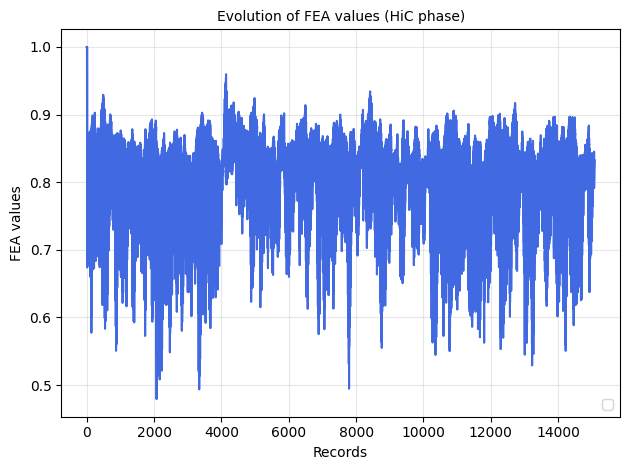

In [19]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

#### MiC

In [18]:
acc_t_switch= pd.read_csv(r".\processed_data\Adult\switch_ds\acc_t_switch")
acc_t_switch = acc_t_switch.rename(columns={'g_truth':'class'})

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=12, hidden_layer1=16, hidden_layer2=8, output_size=2,dropout_coeff= 0.2) # tanto c'è self.eval quindi il dropout non viene avviato
mic_net.to(device)


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [19]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['class']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['class'].values, dtype= torch.long).to(device)


net_path= r".\nets\Adult\acc_t_models\16_8_acc_t_model_30.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.88

In [20]:
acc_t_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.85, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.88, None)


acc_t_mic_df, processed,  mic_acc, model_acc, fea_mic, mach_confidence=acc_t_mic.start_MiC(X_stream, y_stream, acc_t_switch)   #3 minutes

  6%|▌         | 368/6033 [01:48<27:55,  3.38it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.8618158995017466), np.float64(0.8636063172205143), np.float64(0.8653683270993106), np.float64(0.8671025130245485), np.float64(0.5944950472499066)]


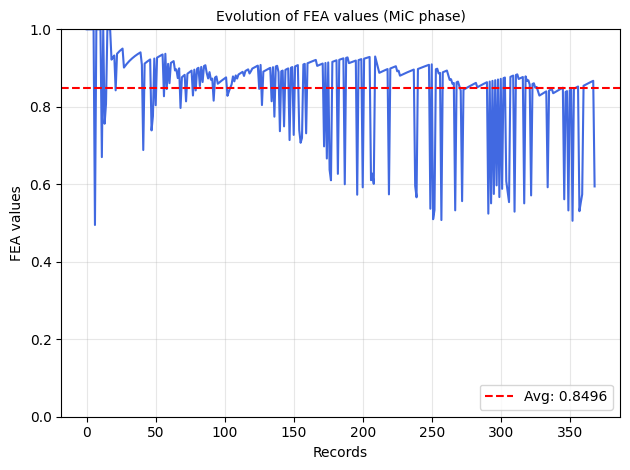

In [21]:
plt.plot(fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [22]:
print(mic_acc)
print(model_acc)
print(np.average(fea_mic))
acc_t_mic.deferred_decisions


0.9349593495934959
0.8265582655826558
0.8495554387691213


145

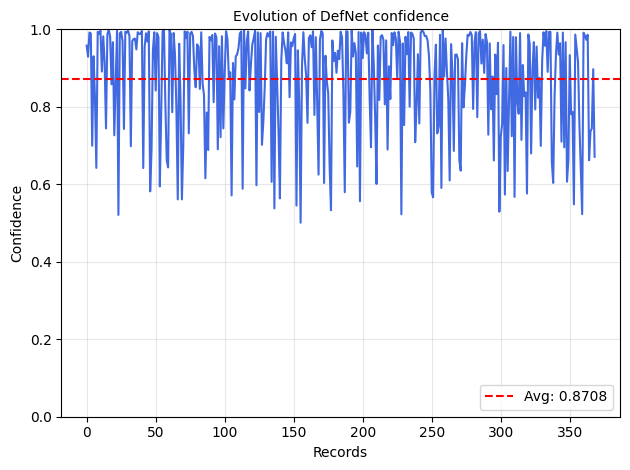

In [23]:
plt.plot(mach_confidence, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

Optimal tau= 0.21428612

In [33]:
r_net_acc_t = DeferralNet(input_size=12, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.2)


r_net_acc_t.load_state_dict(torch.load(r'r_nets/Adult/r_net_acc_t.pth'))
r_net_acc_t.to(device)
r_net_acc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [ ]:
#36 min

acc_t_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.80, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.81, anqi_mao_thresh=0.214286)


acc_t_str_2, _,  mic_acc_2, model_acc_2, fea_mic_2, mach_confidence_2=acc_t_strat_2.start_MiC(X_stream, y_stream, acc_t_switch, r_net= r_net_acc_t, two_step_deferral=True)   #3 minutes

100%|██████████| 6033/6033 [36:53<00:00,  2.73it/s]


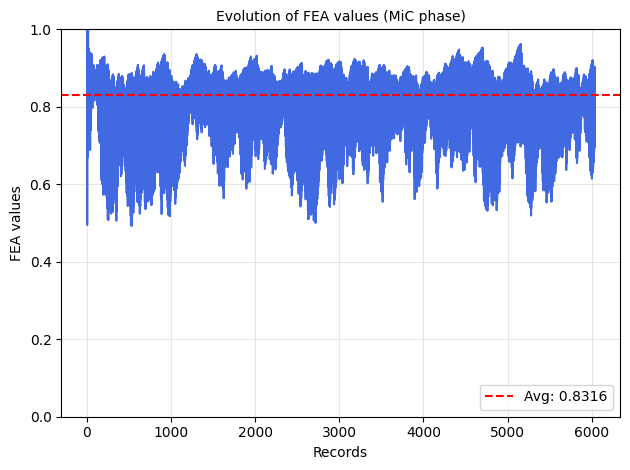

In [35]:
plt.plot(fea_mic_2, linestyle='-', color='royalblue')
avg_fea_2= np.mean(fea_mic_2)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [36]:
print(mic_acc_2)
print(model_acc_2)
print(np.average(fea_mic_2))
acc_t_strat_2.deferred_decisions



0.8233051549809381
0.8312613956572187
0.831568824287399


489

In [37]:
acc_t_mic.stats

{False: {'user': {'tried': 79, 'got': 78, 'conf': 1},
  'machine': {'tried': 286, 'got': 190, 'conf': 0}},
 True: {'user': {'tried': 66, 'got': 54, 'conf': 1},
  'machine': {'tried': 83, 'got': 23, 'conf': 0}}}

In [38]:
acc_t_strat_2.stats

{False: {'user': {'tried': 268, 'got': 268, 'conf': 1},
  'machine': {'tried': 4579, 'got': 3702, 'conf': 0}},
 True: {'user': {'tried': 221, 'got': 104, 'conf': 1},
  'machine': {'tried': 1454, 'got': 893, 'conf': 0}}}

### Expert: Inaccurate, Trusting 

In [16]:
def scale_df(data, pipe, target_c):  # a quanto pare usando questa pipeline di River la label viene persa per strada quindi la devo riattaccarre
    processed_r= []
    labels= data[target_c].values
    X = data.drop(columns=[target_c])

    for i,r in enumerate(X.to_dict(orient='records')):
        scaled_r = pipe.transform_one(r)
        scaled_r[target_c] = labels[i]
        processed_r.append(scaled_r)
    return pd.DataFrame(processed_r)

#### HiC

In [17]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['inaccurate_trusting']
name= f"{'inaccurate_trusting'}"
   

hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, clean_prepr,
                0.90, current_expert,
                protected, categoricals, numericals, 0.7,  0.5,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, rule_att, rule_value, arf_mod
)
    


In [ ]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

inacc_t_hic= pd.DataFrame(hic_df)

inacc_t_hic.to_csv(f".\processed_data\Adult\hic_results_ds\hic_{name}", index=False)  # 43 min

  0%|          | 0/15081 [00:00<?, ?it/s]

  0%|          | 1/15081 [00:02<9:42:05,  2.32s/it]

  0%|          | 8/15081 [00:04<1:55:51,  2.17it/s]

  0%|          | 27/15081 [00:06<46:31,  5.39it/s] 

  0%|          | 50/15081 [00:08<34:31,  7.26it/s]

  0%|          | 66/15081 [00:10<32:47,  7.63it/s]

  0%|          | 72/15081 [00:12<40:19,  6.20it/s]

  1%|          | 83/15081 [00:16<59:03,  4.23it/s]

  1%|          | 104/15081 [00:20<57:38,  4.33it/s]

  1%|          | 105/15081 [00:22<1:22:03,  3.04it/s]

  1%|          | 116/15081 [00:26<1:34:49,  2.63it/s]

  1%|          | 132/15081 [00:30<1:18:50,  3.16it/s]

  1%|          | 143/15081 [00:34<1:30:38,  2.75it/s]

  1%|          | 145/15081 [00:36<1:47:21,  2.32it/s]

  1%|          | 172/15081 [00:41<1:02:02,  4.00it/s]

  1%|          | 176/15081 [00:42<1:10:34,  3.52it/s]

  1%|          | 181/15081 [00:44<1:15:41,  3.28it/s]

  1%|▏         | 201/15081 [00:46<42:49,  5.79it/s]  

  1%|▏         | 215/15081 [00:52<1:13:01,  3.39it/s]

  1%|▏         | 222/15081 [00:57<1:41:31,  2.44it/s]

  2%|▏         | 243/15081 [01:00<56:03,  4.41it/s]  

  2%|▏         | 245/15081 [01:02<1:12:55,  3.39it/s]

  2%|▏         | 259/15081 [01:04<53:45,  4.60it/s]  

  2%|▏         | 276/15081 [01:06<44:53,  5.50it/s]

  2%|▏         | 280/15081 [01:08<54:25,  4.53it/s]

  2%|▏         | 281/15081 [01:10<1:13:00,  3.38it/s]

  2%|▏         | 301/15081 [01:12<43:49,  5.62it/s]  

  2%|▏         | 303/15081 [01:15<1:06:38,  3.70it/s]

  2%|▏         | 311/15081 [01:17<1:04:17,  3.83it/s]

  2%|▏         | 326/15081 [01:20<58:37,  4.19it/s]  

  2%|▏         | 328/15081 [01:23<1:22:10,  2.99it/s]

  2%|▏         | 352/15081 [01:31<1:17:27,  3.17it/s]

  2%|▏         | 363/15081 [01:35<1:26:10,  2.85it/s]

  3%|▎         | 401/15081 [01:37<33:26,  7.32it/s]  

  3%|▎         | 403/15081 [01:39<51:59,  4.71it/s]

  3%|▎         | 410/15081 [01:41<55:38,  4.39it/s]

  3%|▎         | 412/15081 [01:43<1:13:26,  3.33it/s]

  3%|▎         | 415/15081 [01:45<1:27:40,  2.79it/s]

  3%|▎         | 423/15081 [01:48<1:22:00,  2.98it/s]

  3%|▎         | 429/15081 [01:51<1:48:48,  2.24it/s]

  3%|▎         | 452/15081 [01:55<56:32,  4.31it/s]  

  3%|▎         | 454/15081 [01:57<1:18:53,  3.09it/s]

  3%|▎         | 457/15081 [01:59<1:32:02,  2.65it/s]

  3%|▎         | 463/15081 [02:01<1:25:40,  2.84it/s]

  3%|▎         | 470/15081 [02:03<1:19:58,  3.05it/s]

  3%|▎         | 501/15081 [02:06<34:35,  7.02it/s]  

  3%|▎         | 505/15081 [02:08<45:55,  5.29it/s]

  3%|▎         | 524/15081 [02:10<35:45,  6.78it/s]

  4%|▎         | 544/15081 [02:14<42:55,  5.64it/s]

  4%|▎         | 552/15081 [02:18<1:02:37,  3.87it/s]

  4%|▍         | 568/15081 [02:22<1:03:42,  3.80it/s]

  4%|▍         | 581/15081 [02:24<52:32,  4.60it/s]  

  4%|▍         | 582/15081 [02:26<1:10:15,  3.44it/s]

  4%|▍         | 585/15081 [02:28<1:24:33,  2.86it/s]

  4%|▍         | 586/15081 [02:31<2:01:36,  1.99it/s]

  4%|▍         | 588/15081 [02:32<2:17:09,  1.76it/s]

  4%|▍         | 601/15081 [02:37<1:37:05,  2.49it/s]

  4%|▍         | 604/15081 [02:39<2:03:33,  1.95it/s]

  4%|▍         | 644/15081 [02:45<51:08,  4.70it/s]  

  4%|▍         | 647/15081 [02:47<1:09:50,  3.44it/s]

  5%|▍         | 688/15081 [02:53<40:47,  5.88it/s]  

  5%|▍         | 689/15081 [02:56<1:00:40,  3.95it/s]

  5%|▍         | 701/15081 [02:58<53:53,  4.45it/s]  

  5%|▍         | 728/15081 [03:04<53:53,  4.44it/s]  

  5%|▍         | 735/15081 [03:06<1:01:32,  3.88it/s]

  5%|▍         | 744/15081 [03:08<58:32,  4.08it/s]  

  5%|▍         | 746/15081 [03:10<1:15:19,  3.17it/s]

  5%|▌         | 755/15081 [03:13<1:17:30,  3.08it/s]

  5%|▌         | 756/15081 [03:15<1:41:00,  2.36it/s]

  5%|▌         | 789/15081 [03:19<50:10,  4.75it/s]  

  5%|▌         | 791/15081 [03:21<1:04:38,  3.68it/s]

  5%|▌         | 801/15081 [03:24<1:06:24,  3.58it/s]

  5%|▌         | 804/15081 [03:26<1:23:34,  2.85it/s]

  5%|▌         | 827/15081 [03:28<42:24,  5.60it/s]  

  5%|▌         | 828/15081 [03:30<59:11,  4.01it/s]

  6%|▌         | 834/15081 [03:33<1:09:05,  3.44it/s]

  6%|▌         | 856/15081 [03:37<58:31,  4.05it/s]  

  6%|▌         | 914/15081 [03:50<1:01:04,  3.87it/s]

  6%|▌         | 932/15081 [03:56<1:13:44,  3.20it/s]

  6%|▋         | 966/15081 [03:59<29:14,  8.04it/s]  

  7%|▋         | 1025/15081 [04:02<12:57, 18.07it/s]

  7%|▋         | 1045/15081 [04:06<29:22,  7.96it/s]

  7%|▋         | 1051/15081 [04:09<38:36,  6.06it/s]

  7%|▋         | 1082/15081 [04:11<22:51, 10.21it/s]

  7%|▋         | 1125/15081 [04:16<21:49, 10.66it/s]

  8%|▊         | 1186/15081 [04:18<10:03, 23.03it/s]

  8%|▊         | 1202/15081 [04:21<16:14, 14.25it/s]

  8%|▊         | 1214/15081 [04:26<32:40,  7.07it/s]

  8%|▊         | 1230/15081 [04:30<41:44,  5.53it/s]

  8%|▊         | 1236/15081 [04:32<48:47,  4.73it/s]

  8%|▊         | 1262/15081 [04:34<28:26,  8.10it/s]

  9%|▊         | 1303/15081 [04:41<34:05,  6.74it/s]

  9%|▉         | 1337/15081 [04:44<22:47, 10.05it/s]

  9%|▉         | 1401/15081 [04:49<16:30, 13.81it/s]

  9%|▉         | 1416/15081 [04:51<21:52, 10.41it/s]

 10%|█         | 1510/15081 [04:57<14:21, 15.75it/s]

 10%|█         | 1524/15081 [05:00<20:38, 10.95it/s]

 10%|█         | 1567/15081 [05:02<12:23, 18.19it/s]

 11%|█         | 1608/15081 [05:06<13:35, 16.52it/s]

 11%|█         | 1625/15081 [05:08<19:02, 11.78it/s]

 11%|█         | 1649/15081 [05:10<18:09, 12.33it/s]

 11%|█         | 1657/15081 [05:12<26:39,  8.39it/s]

 11%|█         | 1671/15081 [05:15<32:43,  6.83it/s]

 11%|█▏        | 1718/15081 [05:20<18:05, 12.31it/s]

 12%|█▏        | 1774/15081 [05:25<14:24, 15.39it/s]

 13%|█▎        | 1992/15081 [05:41<04:53, 44.67it/s]

 14%|█▎        | 2058/15081 [05:45<05:58, 36.32it/s]

 14%|█▎        | 2070/15081 [05:48<16:16, 13.33it/s]

 14%|█▍        | 2101/15081 [05:57<45:25,  4.76it/s]

 14%|█▍        | 2118/15081 [06:00<33:18,  6.48it/s]  

 15%|█▌        | 2314/15081 [06:18<24:06,  8.83it/s]

 16%|█▌        | 2359/15081 [06:20<11:13, 18.88it/s]

 16%|█▌        | 2380/15081 [06:23<15:02, 14.07it/s]

 18%|█▊        | 2687/15081 [06:41<21:06,  9.79it/s]

 18%|█▊        | 2778/15081 [06:49<08:27, 24.25it/s]

 19%|█▉        | 2851/15081 [06:53<04:54, 41.54it/s]

 19%|█▉        | 2911/15081 [06:56<06:54, 29.37it/s]

 19%|█▉        | 2930/15081 [06:59<14:31, 13.94it/s]

 19%|█▉        | 2937/15081 [07:01<28:26,  7.12it/s]

 20%|█▉        | 2955/15081 [07:05<28:03,  7.20it/s]

 20%|█▉        | 2961/15081 [07:07<39:37,  5.10it/s]

 20%|█▉        | 2965/15081 [07:09<53:44,  3.76it/s]

 22%|██▏       | 3265/15081 [07:23<02:23, 82.31it/s]  

 22%|██▏       | 3275/15081 [07:29<32:36,  6.03it/s]

 23%|██▎       | 3511/15081 [07:35<04:30, 42.80it/s]

 24%|██▍       | 3655/15081 [07:42<04:10, 45.58it/s]

 25%|██▌       | 3833/15081 [07:56<06:28, 28.96it/s]

 26%|██▌       | 3896/15081 [08:02<17:10, 10.85it/s]

 27%|██▋       | 4072/15081 [08:17<04:17, 42.75it/s]

 27%|██▋       | 4080/15081 [08:20<21:55,  8.36it/s]

 28%|██▊       | 4212/15081 [08:29<21:40,  8.36it/s]

 28%|██▊       | 4235/15081 [08:32<16:39, 10.85it/s]

 29%|██▉       | 4369/15081 [08:37<02:54, 61.24it/s]

 30%|██▉       | 4491/15081 [08:42<02:50, 61.99it/s]

 32%|███▏      | 4888/15081 [09:10<26:27,  6.42it/s]

 32%|███▏      | 4898/15081 [09:13<33:09,  5.12it/s]

 34%|███▍      | 5139/15081 [09:28<03:47, 43.69it/s]  

 35%|███▍      | 5204/15081 [09:33<10:12, 16.13it/s]

 35%|███▌      | 5279/15081 [09:45<48:55,  3.34it/s]

 35%|███▌      | 5323/15081 [09:49<09:54, 16.40it/s]  

 35%|███▌      | 5345/15081 [09:53<13:46, 11.78it/s]

 36%|███▌      | 5357/15081 [09:56<28:08,  5.76it/s]

 36%|███▌      | 5368/15081 [10:03<58:07,  2.79it/s]

 36%|███▌      | 5371/15081 [10:06<1:16:53,  2.10it/s]

 36%|███▌      | 5444/15081 [10:27<35:37,  4.51it/s]  

 37%|███▋      | 5562/15081 [10:33<03:19, 47.80it/s]

 37%|███▋      | 5615/15081 [10:38<08:23, 18.81it/s]

 38%|███▊      | 5784/15081 [10:49<04:20, 35.69it/s]

 38%|███▊      | 5795/15081 [10:52<22:46,  6.80it/s]

 39%|███▊      | 5818/15081 [10:57<16:55,  9.12it/s]

 39%|███▊      | 5832/15081 [11:01<25:47,  5.98it/s]

 39%|███▉      | 5847/15081 [11:04<24:42,  6.23it/s]

 40%|███▉      | 5960/15081 [11:11<03:21, 45.32it/s]

 40%|███▉      | 5965/15081 [11:14<33:18,  4.56it/s]

 40%|████      | 6039/15081 [11:24<28:51,  5.22it/s]  

 40%|████      | 6043/15081 [11:28<53:27,  2.82it/s]

 40%|████      | 6096/15081 [11:36<08:03, 18.57it/s]  

 40%|████      | 6101/15081 [11:40<44:53,  3.33it/s]

 41%|████      | 6151/15081 [11:52<41:35,  3.58it/s]  

 41%|████      | 6184/15081 [11:56<10:09, 14.59it/s]  

 41%|████      | 6206/15081 [12:00<19:58,  7.40it/s]

 41%|████▏     | 6255/15081 [12:09<16:32,  8.89it/s]

 42%|████▏     | 6259/15081 [12:12<44:00,  3.34it/s]

 42%|████▏     | 6364/15081 [12:22<23:06,  6.28it/s]  

 44%|████▎     | 6574/15081 [12:52<09:31, 14.88it/s]  

 44%|████▎     | 6582/15081 [12:56<30:25,  4.65it/s]

 44%|████▍     | 6629/15081 [13:15<51:20,  2.74it/s]  

 44%|████▍     | 6652/15081 [13:19<18:58,  7.40it/s]  

 44%|████▍     | 6666/15081 [13:23<23:07,  6.07it/s]

 44%|████▍     | 6706/15081 [13:28<13:27, 10.37it/s]

 45%|████▌     | 6826/15081 [13:47<08:24, 16.36it/s]  

 45%|████▌     | 6857/15081 [13:51<08:21, 16.39it/s]

 46%|████▌     | 6896/15081 [13:59<08:44, 15.60it/s]

 47%|████▋     | 7057/15081 [14:15<04:45, 28.06it/s]

 47%|████▋     | 7066/15081 [14:19<24:55,  5.36it/s]

 47%|████▋     | 7085/15081 [14:29<49:42,  2.68it/s]  

 47%|████▋     | 7088/15081 [14:33<1:13:44,  1.81it/s]

 48%|████▊     | 7291/15081 [14:50<32:14,  4.03it/s]  

 49%|████▉     | 7371/15081 [15:00<03:38, 35.36it/s]  

 49%|████▉     | 7389/15081 [15:04<14:19,  8.95it/s]

 50%|█████     | 7584/15081 [15:41<14:26,  8.65it/s]  

 52%|█████▏    | 7809/15081 [16:13<09:28, 12.78it/s]  

 52%|█████▏    | 7839/15081 [16:24<27:53,  4.33it/s]

 53%|█████▎    | 7966/15081 [16:40<15:54,  7.45it/s]

 54%|█████▍    | 8187/15081 [17:00<06:36, 17.39it/s]

 55%|█████▌    | 8347/15081 [17:28<08:43, 12.87it/s]  

 56%|█████▌    | 8373/15081 [17:40<33:01,  3.38it/s]  

 56%|█████▌    | 8400/15081 [17:44<09:28, 11.76it/s]

 57%|█████▋    | 8547/15081 [18:14<12:18,  8.85it/s]  

 57%|█████▋    | 8639/15081 [18:26<08:14, 13.02it/s]

 59%|█████▉    | 8901/15081 [19:02<18:26,  5.59it/s]  

 59%|█████▉    | 8926/15081 [19:06<08:07, 12.61it/s]

 59%|█████▉    | 8929/15081 [19:11<45:43,  2.24it/s]

 59%|█████▉    | 8948/15081 [19:15<16:58,  6.02it/s]  

 61%|██████▏   | 9240/15081 [20:07<04:13, 23.06it/s]

 65%|██████▌   | 9816/15081 [21:47<42:11,  2.08it/s]  

 65%|██████▌   | 9818/15081 [21:52<1:23:12,  1.05it/s]

 65%|██████▌   | 9826/15081 [21:56<47:43,  1.83it/s]  

 65%|██████▌   | 9858/15081 [22:05<08:58,  9.69it/s]  

 66%|██████▌   | 9880/15081 [22:15<16:21,  5.30it/s]  

 66%|██████▌   | 9907/15081 [22:22<13:46,  6.26it/s]

 66%|██████▌   | 9964/15081 [22:28<03:13, 26.47it/s]

 67%|██████▋   | 10039/15081 [22:49<04:22, 19.21it/s]

 67%|██████▋   | 10167/15081 [23:00<03:05, 26.48it/s]

 67%|██████▋   | 10173/15081 [23:05<29:35,  2.76it/s]

 68%|██████▊   | 10182/15081 [23:09<27:47,  2.94it/s]

 68%|██████▊   | 10191/15081 [23:13<27:34,  2.96it/s]

 68%|██████▊   | 10203/15081 [23:20<39:12,  2.07it/s]

 68%|██████▊   | 10219/15081 [23:26<18:02,  4.49it/s]  

 68%|██████▊   | 10225/15081 [23:30<32:46,  2.47it/s]

 68%|██████▊   | 10248/15081 [23:39<30:27,  2.64it/s]  

 68%|██████▊   | 10251/15081 [23:44<1:01:02,  1.32it/s]

 68%|██████▊   | 10253/15081 [23:48<1:23:26,  1.04s/it]

 68%|██████▊   | 10311/15081 [23:56<09:29,  8.38it/s]  

 69%|██████▊   | 10332/15081 [24:01<07:26, 10.64it/s]

 69%|██████▊   | 10356/15081 [24:11<12:10,  6.47it/s]

 69%|██████▉   | 10440/15081 [24:29<25:13,  3.07it/s]

 69%|██████▉   | 10455/15081 [24:34<15:47,  4.88it/s]

 70%|██████▉   | 10509/15081 [24:43<11:09,  6.83it/s]

 71%|███████   | 10654/15081 [25:29<13:26,  5.49it/s]  

 73%|███████▎  | 10954/15081 [26:25<17:33,  3.92it/s]

 74%|███████▍  | 11221/15081 [27:05<04:32, 14.18it/s]

 78%|███████▊  | 11723/15081 [28:11<04:40, 11.96it/s]  

 78%|███████▊  | 11774/15081 [28:17<02:31, 21.84it/s]

 79%|███████▉  | 11900/15081 [28:29<02:11, 24.10it/s]

 79%|███████▉  | 11927/15081 [28:36<04:08, 12.70it/s]

 79%|███████▉  | 11939/15081 [28:40<09:44,  5.37it/s]

 80%|████████  | 12076/15081 [29:10<28:04,  1.78it/s]

 80%|████████  | 12087/15081 [29:15<16:36,  3.01it/s]

 81%|████████  | 12141/15081 [29:34<19:12,  2.55it/s]

 81%|████████  | 12150/15081 [29:39<19:35,  2.49it/s]

 81%|████████  | 12176/15081 [29:50<11:59,  4.04it/s]

 81%|████████  | 12190/15081 [29:55<10:07,  4.76it/s]

 81%|████████  | 12202/15081 [30:04<28:04,  1.71it/s]

 81%|████████  | 12213/15081 [30:09<15:52,  3.01it/s]

 81%|████████  | 12215/15081 [30:13<37:19,  1.28it/s]

 81%|████████  | 12253/15081 [30:25<23:55,  1.97it/s]  

 81%|████████▏ | 12261/15081 [30:30<21:02,  2.23it/s]

 81%|████████▏ | 12269/15081 [30:40<45:23,  1.03it/s]

 81%|████████▏ | 12284/15081 [30:50<24:41,  1.89it/s]

 82%|████████▏ | 12378/15081 [31:06<02:26, 18.51it/s]

 82%|████████▏ | 12387/15081 [31:11<13:37,  3.30it/s]

 82%|████████▏ | 12395/15081 [31:16<17:06,  2.62it/s]

 82%|████████▏ | 12429/15081 [31:30<22:23,  1.97it/s]

 82%|████████▏ | 12431/15081 [31:35<44:03,  1.00it/s]

 83%|████████▎ | 12470/15081 [31:56<19:04,  2.28it/s]

 83%|████████▎ | 12520/15081 [32:16<04:45,  8.97it/s]

 84%|████████▍ | 12647/15081 [32:39<01:53, 21.37it/s]

 84%|████████▍ | 12655/15081 [32:49<22:30,  1.80it/s]

 84%|████████▍ | 12657/15081 [32:54<42:52,  1.06s/it]

 84%|████████▍ | 12660/15081 [32:59<50:15,  1.25s/it]

 84%|████████▍ | 12730/15081 [33:20<04:55,  7.95it/s]

 85%|████████▍ | 12759/15081 [33:31<15:02,  2.57it/s]

 85%|████████▍ | 12763/15081 [33:36<25:10,  1.53it/s]

 85%|████████▌ | 12827/15081 [33:57<21:29,  1.75it/s]

 87%|████████▋ | 13142/15081 [35:03<01:31, 21.14it/s]

 88%|████████▊ | 13293/15081 [35:37<01:28, 20.20it/s]

 88%|████████▊ | 13320/15081 [35:55<22:58,  1.28it/s]

 89%|████████▉ | 13462/15081 [36:14<01:20, 20.06it/s]

 90%|████████▉ | 13558/15081 [36:27<01:16, 19.96it/s]

 90%|█████████ | 13605/15081 [36:47<08:39,  2.84it/s]

 90%|█████████ | 13631/15081 [37:06<05:43,  4.22it/s]

 91%|█████████ | 13652/15081 [37:17<10:05,  2.36it/s]

 91%|█████████ | 13666/15081 [37:22<04:22,  5.38it/s]

 91%|█████████ | 13685/15081 [37:31<06:11,  3.76it/s]

 91%|█████████ | 13707/15081 [37:41<06:03,  3.78it/s]

 91%|█████████ | 13709/15081 [37:45<19:09,  1.19it/s]

 91%|█████████ | 13712/15081 [37:50<25:01,  1.10s/it]

 92%|█████████▏| 13864/15081 [38:20<01:03, 19.09it/s]

 92%|█████████▏| 13870/15081 [38:25<07:35,  2.66it/s]

 92%|█████████▏| 13909/15081 [38:36<04:18,  4.53it/s]

 93%|█████████▎| 13954/15081 [38:42<00:58, 19.31it/s]

 93%|█████████▎| 13959/15081 [38:47<07:26,  2.51it/s]

 93%|█████████▎| 13998/15081 [38:53<00:57, 18.73it/s]

 93%|█████████▎| 14015/15081 [39:08<13:06,  1.36it/s]

 93%|█████████▎| 14040/15081 [39:19<01:50,  9.40it/s]

 93%|█████████▎| 14045/15081 [39:24<08:19,  2.07it/s]

 93%|█████████▎| 14095/15081 [39:41<01:00, 16.26it/s]

 94%|█████████▍| 14161/15081 [40:11<02:11,  6.99it/s]

 94%|█████████▍| 14182/15081 [40:16<01:23, 10.79it/s]

 95%|█████████▍| 14256/15081 [40:39<08:36,  1.60it/s]

 95%|█████████▌| 14355/15081 [41:12<06:32,  1.85it/s]

 95%|█████████▌| 14379/15081 [41:18<00:53, 13.19it/s]

 95%|█████████▌| 14383/15081 [41:23<06:33,  1.77it/s]

 96%|█████████▌| 14408/15081 [41:37<07:55,  1.42it/s]

 96%|█████████▌| 14503/15081 [41:56<06:45,  1.43it/s]

 96%|█████████▌| 14505/15081 [42:01<10:55,  1.14s/it]

 96%|█████████▋| 14550/15081 [42:08<00:27, 19.37it/s]

 96%|█████████▋| 14553/15081 [42:12<04:52,  1.81it/s]

 97%|█████████▋| 14688/15081 [42:29<00:21, 18.43it/s]

100%|██████████| 15081/15081 [43:47<00:00,  5.74it/s]


In [18]:
blueprint= pd.read_csv(r".\processed_data\Adult\hic_results_ds\hic_inaccurate_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\Adult\calibration_datasets\inacc_t_calibration", index= False)

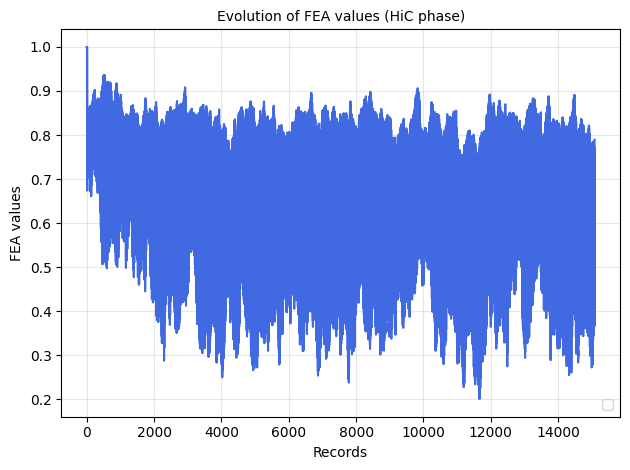

In [22]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### MiC


In [19]:
inacc_t_switch= pd.read_csv(r".\processed_data\Adult\switch_ds\inacc_t_switch")
inacc_t_switch = inacc_t_switch.rename(columns={'g_truth':'class'})

device = torch.device("cpu")

In [20]:
mic_net = DeferralNet(input_size=12, hidden_layer1=16, hidden_layer2=8, output_size=2,dropout_coeff= 0.1) 
mic_net.to(device)

X_stream= torch.tensor(data= df_batch_3.drop(columns=['class']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['class'].values, dtype= torch.long).to(device)


net_path= r".\nets\Adult\inacc_t_models\16_8_model_25.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Confidence-based Deferral
Tau = 0.81

In [21]:
inacc_t_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.85, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, tau_threshold=0.81, anqi_mao_thresh=0.0)


inacc_t_mic_df, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=inacc_t_mic.start_MiC(X_stream, y_stream, inacc_t_switch)   #3 minutes


 11%|█         | 655/6033 [02:53<23:47,  3.77it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.3816578749406242), np.float64(0.8593530622021737), np.float64(0.37313719625419545), np.float64(0.8618864383853241), np.float64(0.8643544084720809)]


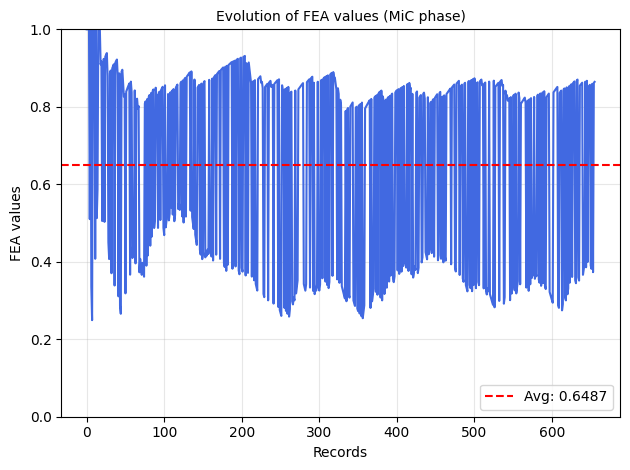

In [25]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [26]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
inacc_t_mic.deferred_decisions

0.5746951219512195
0.6417682926829268


255

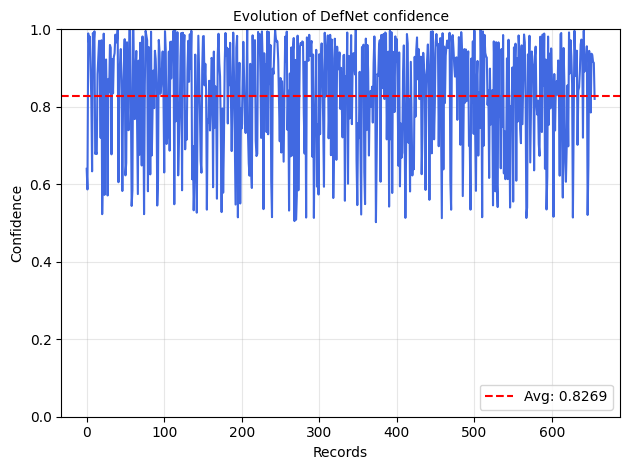

In [27]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

thresh= 0.224490 

In [28]:
r_net_inacc_t = DeferralNet(input_size=12, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.1)

r_net_inacc_t.load_state_dict(torch.load(r'r_nets\Adult\r_net_inacc_t.pth'))
r_net_inacc_t.to(device)
r_net_inacc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [29]:
inacc_t_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.85, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.78, anqi_mao_thresh= 0.224490 )


inacc_t_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=inacc_t_strat_2.start_MiC(X_stream, y_stream, inacc_t_switch, r_net_inacc_t, two_step_deferral=True)   #3 minutes


 11%|█         | 655/6033 [03:29<28:40,  3.13it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.3816578749406242), np.float64(0.8593530622021737), np.float64(0.37313719625419545), np.float64(0.8618864383853241), np.float64(0.8643544084720809)]


In [30]:
print(mic_acc_3)
print(model_acc_3)
inacc_t_strat_2.deferred_decisions


0.6417682926829268
0.6417682926829268


50

### Expert: Accurate, Not Trusting

#### HIC

In [31]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_not_trusting']
name= f"{'accurate_not_trusting'}"

hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, clean_prepr,
                0.90, current_expert,
                protected, categoricals, numericals, 0.7,  0.5,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, rule_att, rule_value, arf_mod
)
    


In [ ]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

hic_df= pd.DataFrame(hic_df)

hic_df.to_csv(f".\processed_data\Adult\hic_results_ds\hic_{name}", index=False)  # 60 minuti

  0%|          | 1/15081 [00:00<1:21:11,  3.10it/s]

  1%|          | 101/15081 [00:04<09:16, 26.89it/s]

  1%|▏         | 210/15081 [00:07<06:00, 41.27it/s]

  2%|▏         | 232/15081 [00:12<14:59, 16.50it/s]

  2%|▏         | 301/15081 [00:14<10:52, 22.64it/s]

  2%|▏         | 352/15081 [00:19<17:02, 14.40it/s]

  3%|▎         | 452/15081 [00:26<19:06, 12.76it/s]

  3%|▎         | 501/15081 [00:29<14:29, 16.78it/s]

  4%|▎         | 560/15081 [00:35<22:57, 10.54it/s]

  4%|▍         | 568/15081 [00:38<31:45,  7.62it/s]

  4%|▍         | 614/15081 [00:43<28:53,  8.35it/s]

  4%|▍         | 633/15081 [00:45<28:40,  8.40it/s]

  5%|▌         | 762/15081 [01:05<48:15,  4.95it/s]

  5%|▌         | 791/15081 [01:10<35:58,  6.62it/s]  

  5%|▌         | 801/15081 [01:13<44:48,  5.31it/s]

  6%|▌         | 869/15081 [01:20<21:23, 11.07it/s]

  6%|▌         | 928/15081 [01:23<11:57, 19.73it/s]

  7%|▋         | 1001/15081 [01:31<21:52, 10.73it/s]

  7%|▋         | 1013/15081 [01:33<27:28,  8.54it/s]

  7%|▋         | 1021/15081 [01:36<38:46,  6.04it/s]

  7%|▋         | 1101/15081 [01:43<23:30,  9.91it/s]

  8%|▊         | 1199/15081 [01:46<05:42, 40.48it/s]

  8%|▊         | 1216/15081 [01:49<17:11, 13.44it/s]

  8%|▊         | 1248/15081 [01:52<15:56, 14.46it/s]

  8%|▊         | 1278/15081 [01:54<15:51, 14.50it/s]

  9%|▊         | 1301/15081 [01:57<20:19, 11.30it/s]

  9%|▉         | 1373/15081 [02:05<16:01, 14.26it/s]

  9%|▉         | 1421/15081 [02:08<11:55, 19.10it/s]

 10%|█         | 1528/15081 [02:14<08:51, 25.49it/s]

 10%|█         | 1572/15081 [02:17<09:25, 23.88it/s]

 11%|█         | 1584/15081 [02:19<19:24, 11.59it/s]

 11%|█         | 1593/15081 [02:22<32:51,  6.84it/s]

 11%|█         | 1600/15081 [02:25<42:12,  5.32it/s]

 11%|█         | 1659/15081 [02:28<10:56, 20.44it/s]

 12%|█▏        | 1739/15081 [02:32<05:45, 38.60it/s]

 12%|█▏        | 1768/15081 [02:34<11:46, 18.85it/s]

 12%|█▏        | 1801/15081 [02:39<17:26, 12.69it/s]

 12%|█▏        | 1876/15081 [02:44<09:37, 22.85it/s]

 13%|█▎        | 1887/15081 [02:47<21:23, 10.28it/s]

 13%|█▎        | 1956/15081 [02:51<07:00, 31.21it/s]

 13%|█▎        | 1993/15081 [02:53<09:35, 22.74it/s]

 13%|█▎        | 2015/15081 [02:59<31:03,  7.01it/s]

 14%|█▎        | 2072/15081 [03:02<09:46, 22.17it/s]

 14%|█▍        | 2083/15081 [03:05<25:14,  8.58it/s]

 14%|█▍        | 2101/15081 [03:08<29:01,  7.45it/s]

 14%|█▍        | 2139/15081 [03:11<16:19, 13.22it/s]

 14%|█▍        | 2147/15081 [03:14<29:01,  7.43it/s]

 15%|█▍        | 2190/15081 [03:23<34:25,  6.24it/s]  

 15%|█▌        | 2299/15081 [03:32<17:18, 12.30it/s]

 16%|█▌        | 2382/15081 [03:38<05:49, 36.32it/s]

 16%|█▌        | 2392/15081 [03:44<41:23,  5.11it/s]

 16%|█▌        | 2414/15081 [03:50<48:56,  4.31it/s]

 16%|█▌        | 2435/15081 [03:53<34:35,  6.09it/s]

 16%|█▋        | 2455/15081 [03:56<32:12,  6.53it/s]

 17%|█▋        | 2537/15081 [04:05<09:52, 21.16it/s]

 17%|█▋        | 2603/15081 [04:12<11:15, 18.46it/s]

 17%|█▋        | 2610/15081 [04:15<27:50,  7.47it/s]

 18%|█▊        | 2643/15081 [04:20<32:41,  6.34it/s]

 18%|█▊        | 2695/15081 [04:24<09:23, 21.98it/s]

 18%|█▊        | 2715/15081 [04:28<19:51, 10.38it/s]

 18%|█▊        | 2774/15081 [04:43<28:37,  7.16it/s]  

 19%|█▊        | 2802/15081 [04:49<39:48,  5.14it/s]

 19%|█▉        | 2853/15081 [04:56<17:14, 11.82it/s]

 19%|█▉        | 2886/15081 [04:59<12:51, 15.81it/s]

 19%|█▉        | 2925/15081 [05:07<41:51,  4.84it/s]

 19%|█▉        | 2939/15081 [05:10<38:44,  5.22it/s]

 20%|██        | 3058/15081 [05:26<14:53, 13.46it/s]  

 20%|██        | 3066/15081 [05:28<29:35,  6.77it/s]

 20%|██        | 3090/15081 [05:35<38:10,  5.24it/s]

 21%|██        | 3137/15081 [05:41<13:53, 14.33it/s]  

 22%|██▏       | 3304/15081 [05:53<07:59, 24.58it/s]

 22%|██▏       | 3330/15081 [05:57<13:29, 14.52it/s]

 22%|██▏       | 3382/15081 [06:04<11:20, 17.19it/s]

 23%|██▎       | 3423/15081 [06:09<10:08, 19.17it/s]

 23%|██▎       | 3437/15081 [06:12<22:32,  8.61it/s]

 23%|██▎       | 3456/15081 [06:15<23:22,  8.29it/s]

 23%|██▎       | 3488/15081 [06:22<45:54,  4.21it/s]

 23%|██▎       | 3509/15081 [06:28<55:48,  3.46it/s]  

 23%|██▎       | 3512/15081 [06:31<1:18:50,  2.45it/s]

 24%|██▍       | 3624/15081 [06:48<10:52, 17.55it/s]  

 24%|██▍       | 3689/15081 [07:00<25:02,  7.58it/s]

 25%|██▍       | 3701/15081 [07:04<40:08,  4.73it/s]

 25%|██▍       | 3733/15081 [07:08<14:34, 12.98it/s]

 25%|██▍       | 3739/15081 [07:14<1:01:54,  3.05it/s]

 25%|██▌       | 3802/15081 [07:24<28:40,  6.55it/s]  

 25%|██▌       | 3813/15081 [07:30<53:23,  3.52it/s]  

 25%|██▌       | 3824/15081 [07:33<51:44,  3.63it/s]  

 25%|██▌       | 3837/15081 [07:37<43:24,  4.32it/s]  

 26%|██▌       | 3849/15081 [07:40<40:15,  4.65it/s]  

 26%|██▌       | 3853/15081 [07:43<1:01:24,  3.05it/s]

 26%|██▌       | 3876/15081 [07:46<26:02,  7.17it/s]  

 26%|██▌       | 3913/15081 [07:56<1:10:07,  2.65it/s]

 26%|██▌       | 3949/15081 [08:00<13:34, 13.66it/s]  

 27%|██▋       | 4080/15081 [08:15<33:58,  5.40it/s]  

 27%|██▋       | 4089/15081 [08:18<45:53,  3.99it/s]  

 27%|██▋       | 4133/15081 [08:23<09:59, 18.25it/s]  

 28%|██▊       | 4170/15081 [08:32<58:12,  3.12it/s]

 28%|██▊       | 4270/15081 [08:44<24:36,  7.32it/s]  

 29%|██▊       | 4300/15081 [08:54<38:21,  4.68it/s]  

 30%|██▉       | 4515/15081 [09:12<15:43, 11.20it/s]  

 31%|███       | 4604/15081 [09:27<10:30, 16.61it/s]  

 32%|███▏      | 4785/15081 [09:44<04:45, 36.01it/s]  

 32%|███▏      | 4795/15081 [09:47<24:56,  6.87it/s]

 32%|███▏      | 4835/15081 [09:55<10:18, 16.55it/s]  

 32%|███▏      | 4890/15081 [10:03<19:32,  8.69it/s]

 32%|███▏      | 4901/15081 [10:10<1:05:31,  2.59it/s]

 33%|███▎      | 4983/15081 [10:19<04:13, 39.78it/s]  

 34%|███▍      | 5191/15081 [10:44<03:33, 46.26it/s]

 35%|███▍      | 5247/15081 [10:53<10:11, 16.08it/s]

 35%|███▌      | 5288/15081 [11:03<38:03,  4.29it/s]

 36%|███▌      | 5363/15081 [11:19<24:51,  6.52it/s]  

 36%|███▌      | 5395/15081 [11:32<46:06,  3.50it/s]  

 40%|███▉      | 5998/15081 [13:01<04:07, 36.65it/s]  

 41%|████      | 6153/15081 [13:28<1:11:11,  2.09it/s]

 41%|████      | 6181/15081 [13:35<21:00,  7.06it/s]  

 42%|████▏     | 6282/15081 [13:42<03:56, 37.22it/s]

 42%|████▏     | 6310/15081 [13:48<14:45,  9.90it/s]

 42%|████▏     | 6372/15081 [13:56<39:18,  3.69it/s]

 42%|████▏     | 6401/15081 [14:01<20:57,  6.91it/s]  

 43%|████▎     | 6500/15081 [14:22<47:55,  2.98it/s]  

 43%|████▎     | 6520/15081 [14:34<1:11:00,  2.01it/s]

 44%|████▍     | 6598/15081 [14:57<24:36,  5.74it/s]  

 44%|████▍     | 6621/15081 [15:02<14:26,  9.76it/s]  

 44%|████▍     | 6653/15081 [15:06<07:46, 18.07it/s]

 44%|████▍     | 6667/15081 [15:10<20:21,  6.89it/s]

 44%|████▍     | 6670/15081 [15:15<1:07:28,  2.08it/s]

 45%|████▌     | 6787/15081 [15:55<1:40:24,  1.38it/s]

 45%|████▌     | 6790/15081 [15:58<1:53:08,  1.22it/s]

 45%|████▌     | 6840/15081 [16:05<05:58, 22.96it/s]  

 46%|████▌     | 6906/15081 [16:19<45:53,  2.97it/s]  

 46%|████▌     | 6910/15081 [16:22<1:10:14,  1.94it/s]

 46%|████▌     | 6943/15081 [16:34<51:38,  2.63it/s]  

 46%|████▌     | 6950/15081 [16:42<1:24:59,  1.59it/s]

 46%|████▌     | 6954/15081 [16:45<1:36:56,  1.40it/s]

 47%|████▋     | 7022/15081 [17:03<1:13:32,  1.83it/s]

 47%|████▋     | 7052/15081 [17:11<13:38,  9.81it/s]  

 47%|████▋     | 7055/15081 [17:14<50:44,  2.64it/s]

 47%|████▋     | 7076/15081 [17:19<17:22,  7.68it/s]  

 47%|████▋     | 7092/15081 [17:23<16:55,  7.87it/s]

 47%|████▋     | 7096/15081 [17:27<53:13,  2.50it/s]

 47%|████▋     | 7125/15081 [17:32<10:57, 12.09it/s]  

 47%|████▋     | 7138/15081 [17:37<23:23,  5.66it/s]

 47%|████▋     | 7149/15081 [17:41<29:44,  4.44it/s]

 48%|████▊     | 7174/15081 [17:45<11:06, 11.87it/s]  

 48%|████▊     | 7206/15081 [17:52<17:33,  7.48it/s]

 48%|████▊     | 7262/15081 [18:05<19:29,  6.69it/s]

 48%|████▊     | 7290/15081 [18:09<08:02, 16.15it/s]

 48%|████▊     | 7294/15081 [18:13<43:26,  2.99it/s]

 48%|████▊     | 7310/15081 [18:23<43:57,  2.95it/s]  

 49%|████▊     | 7350/15081 [18:28<05:58, 21.54it/s]  

 49%|████▉     | 7429/15081 [18:39<05:48, 21.99it/s]

 49%|████▉     | 7447/15081 [18:44<14:16,  8.92it/s]

 49%|████▉     | 7465/15081 [18:48<14:36,  8.69it/s]

 50%|████▉     | 7474/15081 [18:55<1:08:17,  1.86it/s]

 50%|████▉     | 7486/15081 [19:00<38:44,  3.27it/s]  

 50%|████▉     | 7521/15081 [19:06<08:10, 15.42it/s]  

 50%|████▉     | 7527/15081 [19:10<37:08,  3.39it/s]

 50%|████▉     | 7530/15081 [19:13<1:11:45,  1.75it/s]

 50%|████▉     | 7533/15081 [19:18<1:44:25,  1.20it/s]

 50%|█████     | 7541/15081 [19:27<2:06:59,  1.01s/it]

 50%|█████     | 7571/15081 [19:35<38:14,  3.27it/s]  

 50%|█████     | 7574/15081 [19:39<1:18:39,  1.59it/s]

 50%|█████     | 7583/15081 [19:43<52:43,  2.37it/s]  

 50%|█████     | 7593/15081 [19:47<40:10,  3.11it/s]  

 50%|█████     | 7608/15081 [19:56<45:06,  2.76it/s]  

 51%|█████     | 7633/15081 [20:01<10:51, 11.42it/s]  

 51%|█████     | 7637/15081 [20:04<41:57,  2.96it/s]

 51%|█████     | 7644/15081 [20:08<48:13,  2.57it/s]  

 51%|█████     | 7671/15081 [20:24<1:06:32,  1.86it/s]

 51%|█████▏    | 7732/15081 [20:35<05:01, 24.34it/s]  

 51%|█████▏    | 7751/15081 [20:43<38:50,  3.15it/s]

 51%|█████▏    | 7757/15081 [20:47<51:04,  2.39it/s]  

 52%|█████▏    | 7770/15081 [20:52<32:33,  3.74it/s]  

 52%|█████▏    | 7811/15081 [21:02<13:24,  9.04it/s]  

 52%|█████▏    | 7837/15081 [21:07<07:41, 15.70it/s]

 52%|█████▏    | 7847/15081 [21:12<27:44,  4.35it/s]

 52%|█████▏    | 7875/15081 [21:23<22:55,  5.24it/s]  

 52%|█████▏    | 7885/15081 [21:28<33:01,  3.63it/s]  

 53%|█████▎    | 7920/15081 [21:37<08:37, 13.83it/s]  

 53%|█████▎    | 7956/15081 [21:46<07:36, 15.62it/s]  

 54%|█████▍    | 8193/15081 [22:17<06:02, 19.01it/s]

 54%|█████▍    | 8196/15081 [22:20<44:32,  2.58it/s]

 54%|█████▍    | 8205/15081 [22:26<49:02,  2.34it/s]  

 55%|█████▍    | 8220/15081 [22:30<21:33,  5.30it/s]  

 55%|█████▍    | 8260/15081 [22:43<47:15,  2.41it/s]

 55%|█████▌    | 8321/15081 [22:59<34:26,  3.27it/s]  

 55%|█████▌    | 8356/15081 [23:08<19:10,  5.85it/s]  

 56%|█████▌    | 8377/15081 [23:12<10:32, 10.61it/s]

 56%|█████▌    | 8405/15081 [23:23<21:52,  5.09it/s]  

 56%|█████▌    | 8424/15081 [23:27<12:28,  8.89it/s]

 56%|█████▌    | 8457/15081 [23:37<22:15,  4.96it/s]

 56%|█████▌    | 8467/15081 [23:45<46:28,  2.37it/s]  

 56%|█████▌    | 8470/15081 [23:49<1:16:49,  1.43it/s]

 57%|█████▋    | 8576/15081 [24:15<11:35,  9.35it/s]  

 57%|█████▋    | 8636/15081 [24:43<1:07:31,  1.59it/s]

 58%|█████▊    | 8679/15081 [24:56<37:13,  2.87it/s]  

 58%|█████▊    | 8681/15081 [25:00<1:13:58,  1.44it/s]

 58%|█████▊    | 8708/15081 [25:06<17:51,  5.95it/s]  

 58%|█████▊    | 8717/15081 [25:15<1:17:38,  1.37it/s]

 58%|█████▊    | 8793/15081 [25:45<43:28,  2.41it/s]  

 59%|█████▉    | 8954/15081 [26:32<23:28,  4.35it/s]  

 60%|██████    | 9052/15081 [27:04<1:22:11,  1.22it/s]

 60%|██████    | 9055/15081 [27:08<1:39:21,  1.01it/s]

 60%|██████    | 9095/15081 [27:22<59:43,  1.67it/s]  

 60%|██████    | 9104/15081 [27:28<53:43,  1.85it/s]  

 60%|██████    | 9121/15081 [27:36<24:53,  3.99it/s]  

 61%|██████    | 9188/15081 [28:11<56:55,  1.73it/s]  

 61%|██████    | 9218/15081 [28:22<20:08,  4.85it/s]  

 61%|██████▏   | 9266/15081 [28:32<31:01,  3.12it/s]

 62%|██████▏   | 9308/15081 [28:39<12:53,  7.46it/s]

 62%|██████▏   | 9341/15081 [28:45<05:23, 17.76it/s]

 62%|██████▏   | 9362/15081 [28:50<07:59, 11.92it/s]

 62%|██████▏   | 9365/15081 [28:53<42:14,  2.26it/s]

 62%|██████▏   | 9399/15081 [29:02<08:05, 11.69it/s]  

 63%|██████▎   | 9447/15081 [29:18<06:16, 14.97it/s]  

 63%|██████▎   | 9452/15081 [29:22<32:14,  2.91it/s]

 63%|██████▎   | 9466/15081 [29:31<31:27,  2.98it/s]  

 63%|██████▎   | 9487/15081 [29:36<10:31,  8.86it/s]  

 63%|██████▎   | 9565/15081 [29:54<14:18,  6.43it/s]

 64%|██████▎   | 9583/15081 [29:59<10:54,  8.40it/s]

 64%|██████▎   | 9592/15081 [30:03<24:04,  3.80it/s]

 64%|██████▍   | 9631/15081 [30:10<04:52, 18.64it/s]

 64%|██████▍   | 9672/15081 [30:24<08:53, 10.14it/s]  

 64%|██████▍   | 9675/15081 [30:28<41:34,  2.17it/s]

 66%|██████▌   | 9895/15081 [31:14<13:54,  6.21it/s]  

 66%|██████▌   | 9916/15081 [31:25<18:29,  4.66it/s]  

 67%|██████▋   | 10064/15081 [31:56<25:36,  3.27it/s]

 67%|██████▋   | 10075/15081 [32:01<21:22,  3.90it/s]

 67%|██████▋   | 10151/15081 [32:18<25:09,  3.27it/s]  

 67%|██████▋   | 10179/15081 [32:23<05:21, 15.24it/s]

 68%|██████▊   | 10185/15081 [32:28<31:19,  2.60it/s]

 68%|██████▊   | 10195/15081 [32:37<47:40,  1.71it/s]  

 68%|██████▊   | 10201/15081 [32:43<1:06:16,  1.23it/s]

 68%|██████▊   | 10206/15081 [32:47<1:01:03,  1.33it/s]

 68%|██████▊   | 10228/15081 [32:53<09:48,  8.25it/s]  

 68%|██████▊   | 10234/15081 [32:57<29:51,  2.71it/s]

 68%|██████▊   | 10242/15081 [33:02<29:47,  2.71it/s]  

 68%|██████▊   | 10271/15081 [33:07<05:03, 15.83it/s]  

 68%|██████▊   | 10292/15081 [33:16<39:18,  2.03it/s]

 69%|██████▊   | 10356/15081 [33:34<08:29,  9.27it/s]

 69%|██████▊   | 10359/15081 [33:38<38:46,  2.03it/s]

 69%|██████▉   | 10384/15081 [33:43<06:55, 11.31it/s]  

 69%|██████▉   | 10413/15081 [33:51<09:03,  8.60it/s]

 69%|██████▉   | 10419/15081 [33:55<26:42,  2.91it/s]

 69%|██████▉   | 10421/15081 [33:59<1:00:34,  1.28it/s]

 69%|██████▉   | 10423/15081 [34:03<1:22:30,  1.06s/it]

 70%|██████▉   | 10528/15081 [34:26<03:53, 19.51it/s]  

 70%|███████   | 10563/15081 [34:38<30:38,  2.46it/s]

 70%|███████   | 10566/15081 [34:42<58:55,  1.28it/s]

 70%|███████   | 10589/15081 [34:48<09:07,  8.21it/s]  

 70%|███████   | 10610/15081 [34:59<27:40,  2.69it/s]

 71%|███████   | 10657/15081 [35:10<16:35,  4.44it/s]

 71%|███████   | 10707/15081 [35:23<13:40,  5.33it/s]

 71%|███████   | 10714/15081 [35:27<22:54,  3.18it/s]

 71%|███████   | 10719/15081 [35:32<42:16,  1.72it/s]  

 71%|███████   | 10732/15081 [35:41<26:03,  2.78it/s]  

 71%|███████▏  | 10782/15081 [35:55<16:36,  4.31it/s]

 72%|███████▏  | 10896/15081 [36:16<03:11, 21.91it/s]

 73%|███████▎  | 10947/15081 [36:33<04:52, 14.11it/s]  

 73%|███████▎  | 10953/15081 [36:37<23:23,  2.94it/s]

 73%|███████▎  | 11031/15081 [36:56<03:53, 17.31it/s]

 73%|███████▎  | 11059/15081 [37:01<04:27, 15.04it/s]

 73%|███████▎  | 11067/15081 [37:05<17:54,  3.74it/s]

 73%|███████▎  | 11082/15081 [37:19<1:03:21,  1.05it/s]

 74%|███████▎  | 11094/15081 [37:23<21:35,  3.08it/s]  

 74%|███████▍  | 11145/15081 [37:37<04:11, 15.63it/s]

 74%|███████▍  | 11170/15081 [37:51<30:33,  2.13it/s]

 74%|███████▍  | 11197/15081 [37:56<04:25, 14.65it/s]

 75%|███████▍  | 11248/15081 [38:09<08:57,  7.13it/s]

 75%|███████▌  | 11336/15081 [38:39<07:03,  8.84it/s]

 75%|███████▌  | 11349/15081 [38:53<43:22,  1.43it/s]  

 76%|███████▌  | 11408/15081 [39:20<54:14,  1.13it/s]  

 76%|███████▌  | 11463/15081 [39:27<02:54, 20.77it/s]  

 76%|███████▌  | 11499/15081 [39:34<03:21, 17.82it/s]

 77%|███████▋  | 11552/15081 [40:01<12:53,  4.56it/s]

 77%|███████▋  | 11555/15081 [40:05<35:27,  1.66it/s]

 77%|███████▋  | 11589/15081 [40:11<03:39, 15.91it/s]

 77%|███████▋  | 11602/15081 [40:19<29:11,  1.99it/s]

 77%|███████▋  | 11636/15081 [40:34<22:39,  2.53it/s]  

 78%|███████▊  | 11690/15081 [40:50<06:31,  8.66it/s]  

 78%|███████▊  | 11705/15081 [41:02<27:24,  2.05it/s]

 78%|███████▊  | 11757/15081 [41:22<26:56,  2.06it/s]

 78%|███████▊  | 11765/15081 [41:27<23:31,  2.35it/s]

 78%|███████▊  | 11767/15081 [41:32<52:02,  1.06it/s]

 79%|███████▉  | 11881/15081 [41:58<02:47, 19.05it/s]  

 79%|███████▉  | 11887/15081 [42:02<18:13,  2.92it/s]

 79%|███████▉  | 11911/15081 [42:11<09:27,  5.59it/s]

 79%|███████▉  | 11915/15081 [42:15<28:03,  1.88it/s]

 79%|███████▉  | 11938/15081 [42:21<04:53, 10.70it/s]

 79%|███████▉  | 11941/15081 [42:26<26:16,  1.99it/s]

 79%|███████▉  | 11945/15081 [42:30<35:47,  1.46it/s]

 80%|███████▉  | 12051/15081 [42:56<02:30, 20.08it/s]

 80%|███████▉  | 12062/15081 [43:05<38:01,  1.32it/s]

 80%|████████  | 12066/15081 [43:22<2:03:02,  2.45s/it]

 80%|████████  | 12104/15081 [43:33<20:29,  2.42it/s]  

 81%|████████  | 12154/15081 [44:11<21:36,  2.26it/s]  

 81%|████████  | 12249/15081 [44:34<03:05, 15.23it/s]

 81%|████████▏ | 12258/15081 [44:44<30:41,  1.53it/s]

 81%|████████▏ | 12260/15081 [44:49<55:30,  1.18s/it]

 81%|████████▏ | 12276/15081 [44:55<10:27,  4.47it/s]  

 81%|████████▏ | 12278/15081 [45:00<36:49,  1.27it/s]

 82%|████████▏ | 12344/15081 [45:26<20:41,  2.21it/s]  

 82%|████████▏ | 12401/15081 [45:51<30:07,  1.48it/s]

 82%|████████▏ | 12405/15081 [45:56<36:26,  1.22it/s]

 82%|████████▏ | 12413/15081 [46:00<20:47,  2.14it/s]

 83%|████████▎ | 12516/15081 [46:42<06:07,  6.98it/s]  

 83%|████████▎ | 12574/15081 [46:54<02:20, 17.83it/s]

 84%|████████▎ | 12596/15081 [47:05<08:54,  4.65it/s]

 84%|████████▎ | 12622/15081 [47:19<11:41,  3.51it/s]

 84%|████████▍ | 12721/15081 [47:52<08:00,  4.91it/s]

 84%|████████▍ | 12730/15081 [47:57<13:02,  3.00it/s]

 84%|████████▍ | 12732/15081 [48:02<33:53,  1.16it/s]

 85%|████████▍ | 12801/15081 [48:22<18:13,  2.09it/s]

 85%|████████▌ | 12830/15081 [48:36<11:08,  3.37it/s]

 85%|████████▌ | 12862/15081 [48:53<28:52,  1.28it/s]

 85%|████████▌ | 12876/15081 [48:58<07:21,  5.00it/s]

 85%|████████▌ | 12890/15081 [49:06<06:57,  5.24it/s]

 86%|████████▌ | 12906/15081 [49:32<56:27,  1.56s/it]  

 86%|████████▌ | 12908/15081 [49:38<1:08:44,  1.90s/it]

 86%|████████▌ | 12940/15081 [49:48<06:39,  5.36it/s]  

 86%|████████▌ | 12973/15081 [50:03<05:14,  6.71it/s]

 86%|████████▋ | 13008/15081 [50:17<08:24,  4.11it/s]

 86%|████████▋ | 13016/15081 [50:22<10:56,  3.15it/s]

 87%|████████▋ | 13100/15081 [50:40<02:37, 12.57it/s]

 87%|████████▋ | 13129/15081 [50:48<02:13, 14.64it/s]

 88%|████████▊ | 13337/15081 [51:50<22:58,  1.27it/s]

 89%|████████▉ | 13411/15081 [52:27<25:58,  1.07it/s]

 89%|████████▉ | 13421/15081 [52:32<10:33,  2.62it/s]

 90%|█████████ | 13597/15081 [53:05<02:10, 11.39it/s]

 90%|█████████ | 13603/15081 [53:18<28:27,  1.16s/it]

 90%|█████████ | 13616/15081 [53:23<07:16,  3.35it/s]

 91%|█████████ | 13677/15081 [53:48<13:21,  1.75it/s]

 91%|█████████ | 13681/15081 [53:53<18:08,  1.29it/s]

 92%|█████████▏| 13868/15081 [54:40<01:05, 18.47it/s]

 93%|█████████▎| 14015/15081 [55:13<02:08,  8.28it/s]

 93%|█████████▎| 14017/15081 [55:17<13:26,  1.32it/s]

 93%|█████████▎| 14056/15081 [55:28<12:02,  1.42it/s]

 94%|█████████▎| 14105/15081 [55:40<05:19,  3.06it/s]

 94%|█████████▍| 14162/15081 [55:59<01:42,  8.94it/s]

 94%|█████████▍| 14195/15081 [56:10<01:34,  9.34it/s]

 95%|█████████▍| 14297/15081 [56:33<00:45, 17.32it/s]

 97%|█████████▋| 14640/15081 [58:20<00:28, 15.49it/s]

 98%|█████████▊| 14735/15081 [58:51<00:20, 16.56it/s]

100%|█████████▉| 15059/15081 [1:00:16<00:05,  4.33it/s]

100%|█████████▉| 15070/15081 [1:00:21<00:02,  4.33it/s]

100%|██████████| 15081/15081 [1:00:35<00:00,  4.15it/s]


In [32]:
blueprint= pd.read_csv(r".\processed_data\Adult\hic_results_ds\hic_accurate_not_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\Adult\calibration_datasets\acc_nt_calibration", index= False)


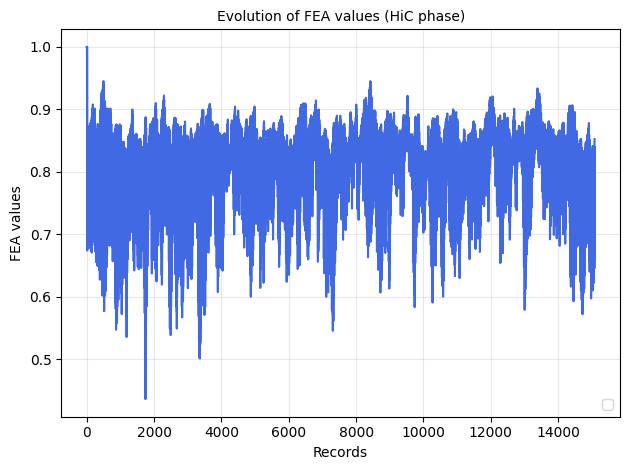

In [26]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print(np.average(hic_feas))

0.7200527222051125


#### MIC

In [33]:
acc_nt_switch= pd.read_csv(r".\processed_data\Adult\switch_ds\acc_nt_switch")
acc_nt_switch = acc_nt_switch.rename(columns={'g_truth':'class'})

device = torch.device("cpu")

In [34]:
mic_net = DeferralNet(input_size=12, hidden_layer1=16, hidden_layer2=8, output_size=2, dropout_coeff= 0.1) 

X_stream= torch.tensor(data= df_batch_3.drop(columns=['class']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['class'].values, dtype= torch.long).to(device)


net_path= r".\nets\Adult\acc_nt_models\16_8_acc_nt_model_23.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Confidence Based Deferral

Tau = 0.9

In [35]:
acc_nt_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.85, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.9, anqi_mao_thresh= 0.181633)


acc_nt_mic_df, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=acc_nt_mic.start_MiC(X_stream, y_stream, acc_nt_switch)   #3 minutes


 18%|█▊        | 1108/6033 [05:33<24:42,  3.32it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.6171310034774176), np.float64(0.83242422734648), np.float64(0.8346936743845533), np.float64(0.6313656245472792), np.float64(0.8369467097010838)]


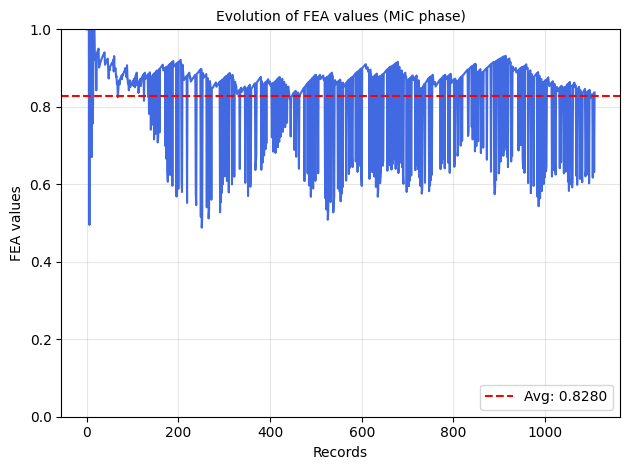

In [36]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [37]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
acc_nt_mic.deferred_decisions

0.7484220018034266
0.8196573489630298


430

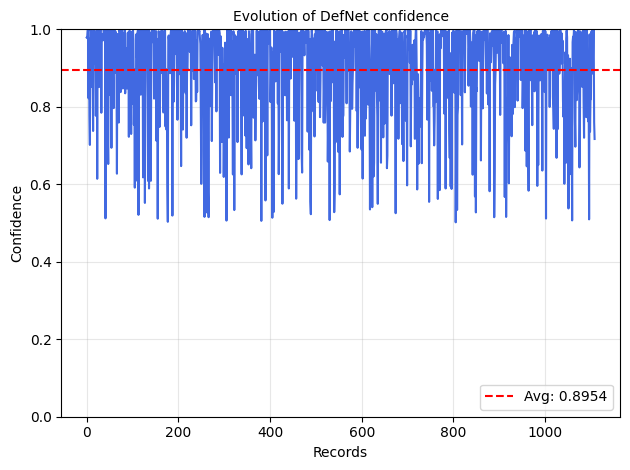

In [38]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

Anqi Mao thresh= 0.181633 

In [39]:
r_net_acc_nt = DeferralNet(input_size=12, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.1)

r_net_acc_nt.load_state_dict(torch.load(r'r_nets\Adult\r_net_acc_nt.pth'))
r_net_acc_nt.to(device)
r_net_acc_nt.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [40]:
acc_nt_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.85, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.77, anqi_mao_thresh= 0.181633 )


acc_nt_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=acc_nt_strat_2.start_MiC(X_stream, y_stream, acc_nt_switch, r_net_acc_nt, two_step_deferral=True)   #3 minutes


 18%|█▊        | 1108/6033 [06:44<29:59,  2.74it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.6171310034774176), np.float64(0.83242422734648), np.float64(0.8346936743845533), np.float64(0.6313656245472792), np.float64(0.8369467097010838)]


In [43]:
print(mic_acc_3)
print(model_acc_3)
acc_nt_strat_2.deferred_decisions


0.7862939585211902
0.8196573489630298


65

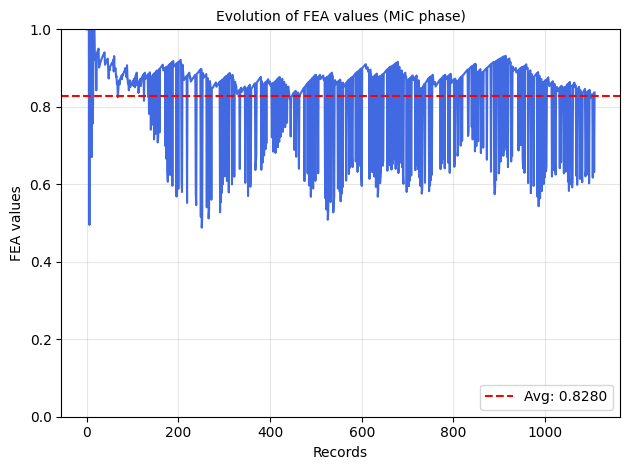

In [42]:
plt.plot(fea_mic_3, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_3)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


### Expert: Inaccurate, Not Trusting

#### HIC

In [44]:
clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['inaccurate_not_trusting']
name= f"{'inaccurate_not_trusting'}"


hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, clean_prepr,
                0.90, current_expert,
                protected, categoricals, numericals, 0.7,  0.5,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, rule_att, rule_value, arf_mod
)
    


In [ ]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

hic_df= pd.DataFrame(hic_df)

hic_df.to_csv(f".\processed_data\Adult\hic_results_ds\hic_{name}", index=False)  # 40 minuti

  0%|          | 1/15081 [00:00<1:15:26,  3.33it/s]

  0%|          | 14/15081 [00:04<1:11:05,  3.53it/s]

  0%|          | 26/15081 [00:06<59:29,  4.22it/s]  

  0%|          | 28/15081 [00:10<2:00:43,  2.08it/s]

  0%|          | 49/15081 [00:14<1:13:58,  3.39it/s]

  0%|          | 52/15081 [00:16<1:28:34,  2.83it/s]

  0%|          | 62/15081 [00:18<1:10:25,  3.55it/s]

  0%|          | 66/15081 [00:20<1:20:26,  3.11it/s]

  0%|          | 71/15081 [00:23<1:33:06,  2.69it/s]

  1%|          | 76/15081 [00:25<1:33:52,  2.66it/s]

  1%|          | 90/15081 [00:28<1:18:38,  3.18it/s]

  1%|          | 111/15081 [00:33<1:02:45,  3.98it/s]

  1%|          | 142/15081 [00:44<1:18:24,  3.18it/s]

  1%|          | 160/15081 [00:48<1:03:35,  3.91it/s]

  1%|          | 176/15081 [00:54<1:23:47,  2.96it/s]

  1%|▏         | 202/15081 [01:01<1:21:58,  3.03it/s]

  1%|▏         | 205/15081 [01:03<1:36:19,  2.57it/s]

  1%|▏         | 217/15081 [01:07<1:33:42,  2.64it/s]

  1%|▏         | 220/15081 [01:11<2:35:42,  1.59it/s]

  1%|▏         | 222/15081 [01:15<3:58:20,  1.04it/s]

  1%|▏         | 225/15081 [01:18<3:50:00,  1.08it/s]

  2%|▏         | 243/15081 [01:20<1:14:15,  3.33it/s]

  2%|▏         | 254/15081 [01:22<1:02:57,  3.93it/s]

  2%|▏         | 257/15081 [01:24<1:15:18,  3.28it/s]

  2%|▏         | 263/15081 [01:26<1:18:07,  3.16it/s]

  2%|▏         | 271/15081 [01:28<1:18:40,  3.14it/s]

  2%|▏         | 277/15081 [01:30<1:19:07,  3.12it/s]

  2%|▏         | 281/15081 [01:32<1:28:58,  2.77it/s]

  2%|▏         | 301/15081 [01:35<50:42,  4.86it/s]  

  2%|▏         | 302/15081 [01:37<1:20:57,  3.04it/s]

  2%|▏         | 314/15081 [01:41<1:24:37,  2.91it/s]

  2%|▏         | 334/15081 [01:43<48:13,  5.10it/s]  

  2%|▏         | 352/15081 [01:46<42:58,  5.71it/s]

  3%|▎         | 379/15081 [01:48<30:27,  8.04it/s]

  3%|▎         | 403/15081 [01:54<1:08:40,  3.56it/s]

  3%|▎         | 437/15081 [02:00<53:07,  4.59it/s]  

  3%|▎         | 454/15081 [02:02<42:17,  5.76it/s]

  3%|▎         | 501/15081 [02:05<20:33, 11.82it/s]  

  3%|▎         | 505/15081 [02:07<28:46,  8.44it/s]

  3%|▎         | 512/15081 [02:09<35:23,  6.86it/s]

  3%|▎         | 524/15081 [02:11<36:52,  6.58it/s]

  4%|▎         | 559/15081 [02:14<26:33,  9.11it/s]

  4%|▎         | 561/15081 [02:16<35:58,  6.73it/s]

  4%|▍         | 575/15081 [02:20<47:58,  5.04it/s]

  4%|▍         | 618/15081 [02:25<33:07,  7.28it/s]

  4%|▍         | 628/15081 [02:27<37:39,  6.40it/s]

  4%|▍         | 636/15081 [02:29<43:40,  5.51it/s]

  4%|▍         | 656/15081 [02:31<34:54,  6.89it/s]

  4%|▍         | 670/15081 [02:34<38:48,  6.19it/s]

  5%|▍         | 687/15081 [02:36<35:22,  6.78it/s]

  5%|▍         | 690/15081 [02:38<46:06,  5.20it/s]

  5%|▍         | 701/15081 [02:40<44:20,  5.40it/s]

  5%|▍         | 706/15081 [02:43<1:01:13,  3.91it/s]

  5%|▌         | 778/15081 [02:59<37:00,  6.44it/s]  

  5%|▌         | 781/15081 [03:01<53:25,  4.46it/s]

  5%|▌         | 783/15081 [03:03<1:10:15,  3.39it/s]

  5%|▌         | 801/15081 [03:06<45:04,  5.28it/s]  

  5%|▌         | 804/15081 [03:08<1:00:53,  3.91it/s]

  5%|▌         | 813/15081 [03:12<1:24:49,  2.80it/s]

  5%|▌         | 819/15081 [03:17<1:58:53,  2.00it/s]

  5%|▌         | 827/15081 [03:19<1:32:39,  2.56it/s]

  5%|▌         | 828/15081 [03:21<2:13:54,  1.77it/s]

  6%|▌         | 834/15081 [03:23<1:53:30,  2.09it/s]

  6%|▌         | 903/15081 [03:37<42:29,  5.56it/s]  

  6%|▌         | 920/15081 [03:42<54:15,  4.35it/s]

  6%|▌         | 931/15081 [03:44<50:44,  4.65it/s]

  6%|▌         | 942/15081 [03:48<1:04:54,  3.63it/s]

  6%|▋         | 946/15081 [03:51<1:23:05,  2.84it/s]

  6%|▋         | 968/15081 [03:53<48:01,  4.90it/s]  

  7%|▋         | 988/15081 [03:57<47:13,  4.97it/s]

  7%|▋         | 992/15081 [04:00<1:02:07,  3.78it/s]

  7%|▋         | 995/15081 [04:02<1:14:35,  3.15it/s]

  7%|▋         | 1014/15081 [04:09<1:19:41,  2.94it/s]

  7%|▋         | 1050/15081 [04:14<30:09,  7.75it/s]  

  7%|▋         | 1062/15081 [04:16<33:59,  6.87it/s]

  7%|▋         | 1074/15081 [04:18<36:26,  6.41it/s]

  7%|▋         | 1079/15081 [04:25<1:19:46,  2.93it/s]

  7%|▋         | 1083/15081 [04:27<1:25:59,  2.71it/s]

  7%|▋         | 1086/15081 [04:29<1:36:55,  2.41it/s]

  7%|▋         | 1101/15081 [04:34<1:20:22,  2.90it/s]

  7%|▋         | 1103/15081 [04:36<1:41:38,  2.29it/s]

  7%|▋         | 1115/15081 [04:39<1:09:39,  3.34it/s]

  7%|▋         | 1116/15081 [04:41<1:43:28,  2.25it/s]

  7%|▋         | 1122/15081 [04:43<1:34:55,  2.45it/s]

  7%|▋         | 1130/15081 [04:45<1:22:31,  2.82it/s]

  8%|▊         | 1133/15081 [04:47<1:34:51,  2.45it/s]

  8%|▊         | 1136/15081 [04:50<1:49:23,  2.12it/s]

  8%|▊         | 1164/15081 [04:57<1:16:02,  3.05it/s]

  8%|▊         | 1179/15081 [05:03<1:32:52,  2.49it/s]

  8%|▊         | 1201/15081 [05:06<48:06,  4.81it/s]  

  8%|▊         | 1239/15081 [05:13<39:51,  5.79it/s]  

  8%|▊         | 1243/15081 [05:15<50:40,  4.55it/s]

  9%|▊         | 1317/15081 [05:25<41:15,  5.56it/s]

  9%|▉         | 1429/15081 [05:33<22:44, 10.01it/s]

 10%|▉         | 1437/15081 [05:36<30:12,  7.53it/s]

 10%|█         | 1513/15081 [05:40<14:28, 15.62it/s]

 10%|█         | 1527/15081 [05:42<21:18, 10.60it/s]

 10%|█         | 1572/15081 [05:52<30:16,  7.44it/s]

 11%|█         | 1674/15081 [05:56<06:30, 34.34it/s]

 12%|█▏        | 1775/15081 [06:04<13:46, 16.10it/s]

 12%|█▏        | 1786/15081 [06:09<35:59,  6.16it/s]

 12%|█▏        | 1819/15081 [06:17<44:51,  4.93it/s]

 12%|█▏        | 1829/15081 [06:19<50:53,  4.34it/s]

 12%|█▏        | 1870/15081 [06:27<33:13,  6.63it/s]  

 13%|█▎        | 1957/15081 [06:35<20:34, 10.63it/s]

 13%|█▎        | 1980/15081 [06:41<30:22,  7.19it/s]

 14%|█▎        | 2067/15081 [06:49<20:09, 10.76it/s]

 14%|█▍        | 2075/15081 [06:54<47:23,  4.57it/s]

 14%|█▍        | 2081/15081 [06:57<55:16,  3.92it/s]

 14%|█▍        | 2136/15081 [07:10<1:01:09,  3.53it/s]

 14%|█▍        | 2180/15081 [07:13<20:23, 10.54it/s]  

 15%|█▍        | 2242/15081 [07:16<08:51, 24.13it/s]

 15%|█▌        | 2263/15081 [07:23<32:40,  6.54it/s]

 15%|█▌        | 2269/15081 [07:25<42:34,  5.02it/s]

 15%|█▌        | 2301/15081 [07:31<29:42,  7.17it/s]  

 15%|█▌        | 2313/15081 [07:34<35:39,  5.97it/s]

 15%|█▌        | 2317/15081 [07:36<49:16,  4.32it/s]

 16%|█▌        | 2406/15081 [07:41<08:30, 24.83it/s]

 16%|█▌        | 2440/15081 [07:43<10:20, 20.36it/s]

 17%|█▋        | 2526/15081 [07:47<04:52, 42.88it/s]

 17%|█▋        | 2630/15081 [07:53<06:44, 30.77it/s]

 18%|█▊        | 2686/15081 [08:01<19:12, 10.75it/s]

 18%|█▊        | 2713/15081 [08:04<17:44, 11.62it/s]

 18%|█▊        | 2733/15081 [08:08<22:41,  9.07it/s]

 19%|█▊        | 2796/15081 [08:15<23:04,  8.88it/s]

 20%|██        | 3027/15081 [08:29<17:51, 11.25it/s]

 21%|██        | 3125/15081 [08:36<10:35, 18.80it/s]

 21%|██        | 3170/15081 [08:42<18:31, 10.71it/s]

 22%|██▏       | 3272/15081 [08:49<05:10, 38.09it/s]

 22%|██▏       | 3390/15081 [08:58<28:13,  6.90it/s]

 23%|██▎       | 3420/15081 [09:02<18:33, 10.47it/s]

 23%|██▎       | 3508/15081 [09:11<08:59, 21.47it/s]

 24%|██▍       | 3591/15081 [09:20<07:29, 25.57it/s]

 24%|██▍       | 3657/15081 [09:26<21:05,  9.03it/s]

 25%|██▍       | 3747/15081 [09:39<17:11, 10.98it/s]  

 25%|██▍       | 3762/15081 [09:43<26:21,  7.16it/s]

 26%|██▌       | 3919/15081 [09:53<04:56, 37.65it/s]

 26%|██▌       | 3933/15081 [09:56<17:49, 10.43it/s]

 26%|██▋       | 3963/15081 [10:00<14:34, 12.71it/s]

 26%|██▋       | 3977/15081 [10:03<23:31,  7.86it/s]

 26%|██▋       | 3982/15081 [10:06<40:38,  4.55it/s]

 28%|██▊       | 4231/15081 [10:17<03:32, 51.18it/s]

 28%|██▊       | 4244/15081 [10:22<32:05,  5.63it/s]

 29%|██▊       | 4332/15081 [10:27<04:36, 38.85it/s]

 30%|███       | 4525/15081 [10:40<41:25,  4.25it/s]

 31%|███       | 4685/15081 [10:53<03:24, 50.92it/s]

 31%|███▏      | 4738/15081 [10:58<05:59, 28.78it/s]

 32%|███▏      | 4831/15081 [11:06<07:17, 23.42it/s]

 32%|███▏      | 4837/15081 [11:10<35:47,  4.77it/s]

 32%|███▏      | 4879/15081 [11:13<08:35, 19.80it/s]

 32%|███▏      | 4886/15081 [11:16<30:12,  5.62it/s]

 32%|███▏      | 4892/15081 [11:20<46:31,  3.65it/s]

 33%|███▎      | 4945/15081 [11:25<06:54, 24.45it/s]  

 33%|███▎      | 4990/15081 [11:29<05:52, 28.62it/s]

 34%|███▎      | 5055/15081 [11:34<03:56, 42.37it/s]

 34%|███▍      | 5094/15081 [11:41<10:56, 15.22it/s]

 34%|███▍      | 5103/15081 [11:45<41:14,  4.03it/s]

 34%|███▍      | 5111/15081 [11:48<47:32,  3.50it/s]  

 34%|███▍      | 5138/15081 [11:52<15:59, 10.36it/s]  

 34%|███▍      | 5167/15081 [11:56<11:31, 14.34it/s]

 34%|███▍      | 5186/15081 [12:00<20:38,  7.99it/s]

 35%|███▍      | 5219/15081 [12:04<11:52, 13.84it/s]

 35%|███▍      | 5224/15081 [12:08<37:18,  4.40it/s]

 35%|███▍      | 5245/15081 [12:11<21:10,  7.74it/s]

 35%|███▍      | 5268/15081 [12:18<26:42,  6.12it/s]  

 35%|███▌      | 5319/15081 [12:30<15:17, 10.64it/s]  

 36%|███▌      | 5384/15081 [12:44<40:42,  3.97it/s]

 36%|███▌      | 5407/15081 [12:52<40:14,  4.01it/s]  

 36%|███▌      | 5427/15081 [12:55<21:17,  7.55it/s]  

 36%|███▌      | 5455/15081 [12:59<12:16, 13.07it/s]

 36%|███▋      | 5489/15081 [13:07<13:34, 11.78it/s]  

 37%|███▋      | 5553/15081 [13:15<10:36, 14.96it/s]

 37%|███▋      | 5558/15081 [13:18<37:11,  4.27it/s]

 38%|███▊      | 5722/15081 [13:34<19:52,  7.85it/s]

 38%|███▊      | 5783/15081 [13:38<04:07, 37.52it/s]

 38%|███▊      | 5804/15081 [13:46<48:03,  3.22it/s]

 40%|███▉      | 6008/15081 [13:59<09:02, 16.73it/s]  

 40%|████      | 6038/15081 [14:07<33:54,  4.45it/s]

 40%|████      | 6054/15081 [14:11<26:56,  5.58it/s]

 41%|████      | 6172/15081 [14:21<03:16, 45.33it/s]

 41%|████      | 6196/15081 [14:26<12:12, 12.13it/s]

 41%|████▏     | 6251/15081 [14:38<39:38,  3.71it/s]

 41%|████▏     | 6254/15081 [14:42<1:11:28,  2.06it/s]

 42%|████▏     | 6389/15081 [14:52<03:41, 39.29it/s]  

 43%|████▎     | 6456/15081 [14:58<03:42, 38.84it/s]

 43%|████▎     | 6519/15081 [15:08<34:04,  4.19it/s]

 44%|████▍     | 6652/15081 [15:22<03:45, 37.34it/s]

 44%|████▍     | 6666/15081 [15:25<16:47,  8.35it/s]

 45%|████▍     | 6721/15081 [15:31<06:21, 21.89it/s]

 47%|████▋     | 7059/15081 [16:00<03:55, 34.02it/s]  

 47%|████▋     | 7068/15081 [16:04<25:36,  5.22it/s]

 48%|████▊     | 7294/15081 [16:24<16:14,  7.99it/s]

 49%|████▊     | 7326/15081 [16:30<08:33, 15.10it/s]

 49%|████▉     | 7442/15081 [16:44<07:21, 17.32it/s]

 50%|████▉     | 7502/15081 [16:51<14:39,  8.61it/s]

 51%|█████     | 7704/15081 [17:10<14:06,  8.71it/s]  

 52%|█████▏    | 7783/15081 [17:16<03:14, 37.58it/s]

 52%|█████▏    | 7815/15081 [17:21<09:43, 12.46it/s]

 52%|█████▏    | 7831/15081 [17:25<15:10,  7.96it/s]

 54%|█████▍    | 8117/15081 [17:47<06:03, 19.14it/s]

 54%|█████▍    | 8201/15081 [17:54<14:53,  7.70it/s]

 55%|█████▌    | 8310/15081 [18:08<23:24,  4.82it/s]

 56%|█████▋    | 8485/15081 [18:25<04:10, 26.29it/s]

 57%|█████▋    | 8596/15081 [18:41<13:36,  7.94it/s]

 60%|██████    | 9077/15081 [20:03<07:59, 12.53it/s]  

 61%|██████▏   | 9247/15081 [20:22<03:31, 27.57it/s]

 61%|██████▏   | 9254/15081 [20:27<27:54,  3.48it/s]

 62%|██████▏   | 9388/15081 [20:37<03:03, 31.05it/s]

 63%|██████▎   | 9449/15081 [20:48<04:55, 19.07it/s]

 63%|██████▎   | 9463/15081 [20:53<15:02,  6.22it/s]

 63%|██████▎   | 9482/15081 [21:01<21:37,  4.32it/s]

 63%|██████▎   | 9502/15081 [21:06<25:28,  3.65it/s]

 63%|██████▎   | 9507/15081 [21:11<44:21,  2.09it/s]  

 64%|██████▎   | 9588/15081 [21:17<03:01, 30.19it/s]  

 64%|██████▍   | 9665/15081 [21:33<07:38, 11.82it/s]

 64%|██████▍   | 9668/15081 [21:37<38:50,  2.32it/s]

 64%|██████▍   | 9699/15081 [21:45<11:27,  7.82it/s]

 65%|██████▌   | 9822/15081 [22:08<12:49,  6.84it/s]  

 67%|██████▋   | 10075/15081 [22:32<02:52, 29.02it/s]

 68%|██████▊   | 10199/15081 [22:42<02:53, 28.16it/s]

 68%|██████▊   | 10242/15081 [22:49<03:19, 24.28it/s]

 70%|██████▉   | 10508/15081 [23:25<10:40,  7.14it/s]  

 70%|███████   | 10578/15081 [23:42<12:17,  6.11it/s]  

 70%|███████   | 10608/15081 [23:50<12:26,  5.99it/s]

 70%|███████   | 10629/15081 [23:54<06:49, 10.88it/s]

 71%|███████   | 10653/15081 [23:59<05:16, 13.97it/s]

 71%|███████   | 10732/15081 [24:12<03:05, 23.48it/s]  

 72%|███████▏  | 10906/15081 [24:31<13:52,  5.02it/s]

 72%|███████▏  | 10909/15081 [24:35<37:47,  1.84it/s]

 73%|███████▎  | 11026/15081 [25:01<03:33, 19.01it/s]

 74%|███████▍  | 11206/15081 [25:24<13:15,  4.87it/s]

 75%|███████▌  | 11312/15081 [25:44<59:05,  1.06it/s]

 75%|███████▌  | 11334/15081 [25:49<07:50,  7.97it/s]  

 75%|███████▌  | 11378/15081 [25:59<10:55,  5.65it/s]

 76%|███████▌  | 11390/15081 [26:03<13:15,  4.64it/s]

 76%|███████▋  | 11524/15081 [26:22<03:44, 15.84it/s]

 77%|███████▋  | 11635/15081 [26:34<02:45, 20.80it/s]

 77%|███████▋  | 11668/15081 [26:44<05:52,  9.67it/s]

 78%|███████▊  | 11689/15081 [26:49<05:21, 10.54it/s]

 78%|███████▊  | 11800/15081 [27:01<02:21, 23.18it/s]

 79%|███████▉  | 11901/15081 [27:15<17:32,  3.02it/s]

 79%|███████▉  | 11936/15081 [27:21<02:50, 18.49it/s]

 79%|███████▉  | 11978/15081 [27:27<02:28, 20.85it/s]

 80%|███████▉  | 11993/15081 [27:33<08:12,  6.27it/s]

 80%|███████▉  | 12049/15081 [27:42<02:13, 22.73it/s]

 80%|███████▉  | 12052/15081 [27:46<22:53,  2.20it/s]

 81%|████████  | 12182/15081 [28:16<05:35,  8.65it/s]

 81%|████████  | 12212/15081 [28:24<07:27,  6.41it/s]

 81%|████████  | 12214/15081 [28:29<32:23,  1.48it/s]

 81%|████████  | 12252/15081 [28:35<02:32, 18.57it/s]

 81%|████████▏ | 12267/15081 [28:44<25:49,  1.82it/s]

 81%|████████▏ | 12278/15081 [28:49<16:11,  2.88it/s]

 81%|████████▏ | 12280/15081 [28:54<35:32,  1.31it/s]

 82%|████████▏ | 12308/15081 [29:06<10:40,  4.33it/s]  

 82%|████████▏ | 12382/15081 [29:13<01:58, 22.85it/s]

 83%|████████▎ | 12590/15081 [29:56<01:51, 22.42it/s]

 84%|████████▍ | 12706/15081 [30:21<11:51,  3.34it/s]

 85%|████████▌ | 12894/15081 [30:55<04:13,  8.62it/s]

 87%|████████▋ | 13108/15081 [31:23<07:05,  4.64it/s]

 87%|████████▋ | 13158/15081 [31:35<08:08,  3.94it/s]

 87%|████████▋ | 13169/15081 [31:39<07:56,  4.01it/s]

 87%|████████▋ | 13180/15081 [31:44<07:57,  3.99it/s]

 87%|████████▋ | 13185/15081 [31:49<15:19,  2.06it/s]

 88%|████████▊ | 13201/15081 [31:58<17:57,  1.75it/s]

 88%|████████▊ | 13294/15081 [32:14<01:22, 21.57it/s]

 88%|████████▊ | 13313/15081 [32:28<16:40,  1.77it/s]

 88%|████████▊ | 13318/15081 [32:33<19:57,  1.47it/s]

 88%|████████▊ | 13320/15081 [32:37<31:07,  1.06s/it]

 88%|████████▊ | 13343/15081 [32:43<03:09,  9.17it/s]

 89%|████████▊ | 13376/15081 [32:53<01:57, 14.57it/s]

 89%|████████▉ | 13391/15081 [32:57<03:36,  7.79it/s]

 89%|████████▉ | 13478/15081 [33:23<04:34,  5.84it/s]

 90%|█████████ | 13613/15081 [33:54<03:20,  7.34it/s]

 90%|█████████ | 13643/15081 [34:00<01:30, 15.82it/s]

 91%|█████████ | 13653/15081 [34:05<05:57,  4.00it/s]

 91%|█████████ | 13671/15081 [34:15<04:01,  5.83it/s]

 91%|█████████ | 13706/15081 [34:24<05:24,  4.24it/s]

 91%|█████████ | 13749/15081 [34:31<01:08, 19.43it/s]

 91%|█████████▏| 13763/15081 [34:36<03:06,  7.07it/s]

 91%|█████████▏| 13797/15081 [34:42<01:12, 17.67it/s]

 92%|█████████▏| 13852/15081 [34:53<01:02, 19.51it/s]

 92%|█████████▏| 13858/15081 [34:58<07:24,  2.75it/s]

 92%|█████████▏| 13873/15081 [35:03<03:06,  6.47it/s]

 93%|█████████▎| 14002/15081 [35:30<11:34,  1.55it/s]

 93%|█████████▎| 14011/15081 [35:35<06:30,  2.74it/s]

 93%|█████████▎| 14014/15081 [35:39<13:31,  1.31it/s]

 93%|█████████▎| 14021/15081 [35:49<15:30,  1.14it/s]

 93%|█████████▎| 14033/15081 [35:58<12:04,  1.45it/s]

 93%|█████████▎| 14054/15081 [36:07<03:28,  4.92it/s]

 93%|█████████▎| 14080/15081 [36:14<01:12, 13.88it/s]

 94%|█████████▎| 14136/15081 [36:29<05:07,  3.08it/s]

 94%|█████████▍| 14213/15081 [36:41<02:15,  6.38it/s]

 95%|█████████▍| 14278/15081 [36:54<00:53, 14.96it/s]

100%|█████████▉| 15042/15081 [38:38<00:02, 17.70it/s]

100%|█████████▉| 15044/15081 [38:43<00:27,  1.36it/s]

100%|██████████| 15081/15081 [39:00<00:00,  6.44it/s]


In [45]:
blueprint= pd.read_csv(r".\processed_data\Adult\hic_results_ds\hic_inaccurate_not_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]]

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\Adult\calibration_datasets\inacc_nt_calibration", index= False)


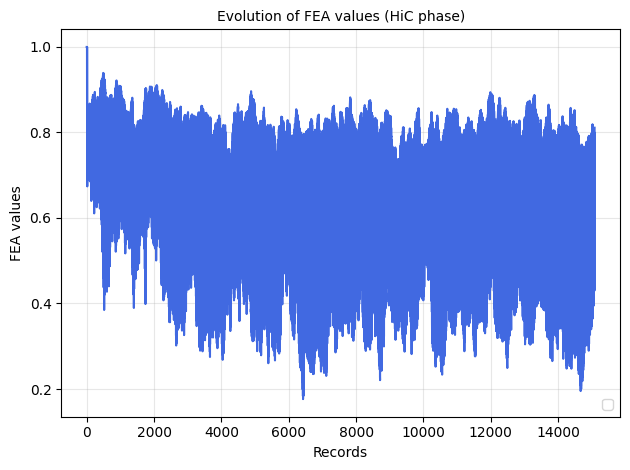

In [30]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### MIC

In [46]:
inacc_nt_switch= pd.read_csv(r".\processed_data\Adult\switch_ds\inacc_nt_switch")
inacc_nt_switch = inacc_nt_switch.rename(columns={'g_truth':'class'})

device = torch.device("cpu")

In [48]:
mic_net = DeferralNet(input_size=12, hidden_layer1=16, hidden_layer2=8, output_size=2,dropout_coeff= 0.4) 
mic_net.to(device)

X_stream= torch.tensor(data= df_batch_3.drop(columns=['class']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['class'].values, dtype= torch.long).to(device)


net_path= r".\nets\Adult\inacc_nt_models\16_8_inacc_nt_model_11.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Deferral Strat 1

tau= 0.69

anqi mao = 0.193878

In [49]:
inacc_nt_mic_strat_1= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.85, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.69, anqi_mao_thresh= 0.193878)


inacc_nt_mic, _,  system_acc_inaccurate, model_acc_inaccurate, fea_mic_in, mach_confidence_in=inacc_nt_mic_strat_1.start_MiC(X_stream, y_stream, inacc_nt_switch)   #3 minutes


  8%|▊         | 506/6033 [02:43<29:45,  3.10it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.267617781883321), np.float64(0.8088264227646064), np.float64(0.8119406961676353), np.float64(0.28658698625232293), np.float64(0.2792803660281649)]


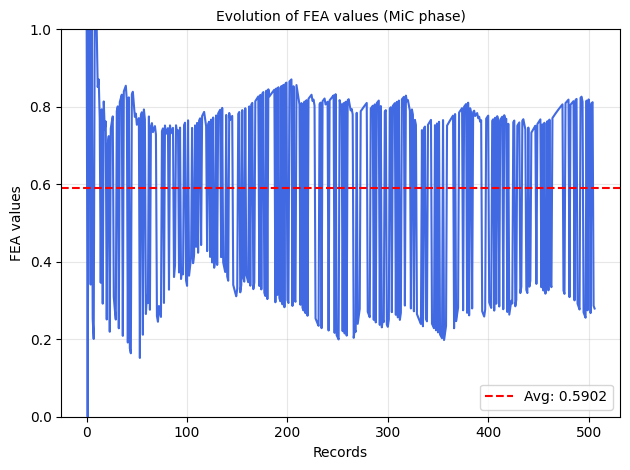

In [52]:
plt.plot(fea_mic_in, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic_in)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()


In [53]:
print(system_acc_inaccurate)
print(model_acc_inaccurate)
inacc_nt_mic_strat_1.deferred_decisions

0.5581854043392505
0.5877712031558185


195

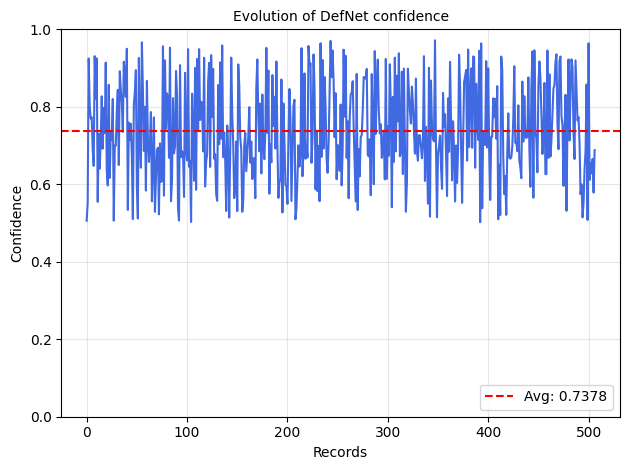

In [54]:
plt.plot(mach_confidence_in, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence_in)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Deferral Strat 2

anqi mao thresh= 0.193878

In [55]:
r_net_inacc_nt = DeferralNet(input_size=12, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.3)

r_net_inacc_nt.load_state_dict(torch.load(r'r_nets\Adult\r_net_inacc_nt.pth'))
r_net_inacc_nt.to(device)
r_net_inacc_nt.eval()

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [56]:
inacc_nt_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.85, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.69, anqi_mao_thresh= 0.193878)


inacc_nt_mic_df, _,  mic_acc_3, model_acc_3, fea_mic_3, mach_confidence_3=inacc_nt_strat_2.start_MiC(X_stream, y_stream, acc_nt_switch, r_net_acc_nt, two_step_deferral=True)   #3 minutes


  8%|▊         | 506/6033 [03:12<35:04,  2.63it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.267617781883321), np.float64(0.8088264227646064), np.float64(0.8119406961676353), np.float64(0.28658698625232293), np.float64(0.2792803660281649)]


In [58]:
print(mic_acc_3)
print(model_acc_3)
inacc_nt_strat_2.deferred_decisions


0.5759368836291914
0.5877712031558185


14